# Dynamic Thermal Model of a Gas-Insulated Substation Floor

Author: *Mateo Tournoud*  
Course: Dynamic Models for Building Energy Management (dm4bem)  

This notebook documents the modelling and simulation of the second floor of a gas-insulated substation located in Dübendorf, Switzerland. The model is developed with the `dm4bem` Python module and follows the methodology presented in *Dynamic Models for Building Energy Management* by C. Ghiaus.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mateotournoud/Tournoud_rEVA_CE4IB/main?urlpath=%2Fdoc%2Ftree%2Ftournoud_ce4ib.ipynb)


# Introduction

## Description of the topic

Electrical substations often contain sensitive power-electronics and switching equipment that generate substantial heat gains. In gas-insulated substations (GIS), equipment is frequently placed in compact enclosures with limited natural ventilation. Maintaining acceptable indoor temperatures is essential for equipment reliability and safety, while avoiding excessive energy use for heating, ventilation and air conditioning (HVAC).

In this project, I develop a dynamic thermal model of the **second floor** of such a substation in Dübendorf, Switzerland. The floor is bounded by four external walls with windows, a flat roof hosting photovoltaic (PV) panels, and an **adiabatic floor** in contact with the building interior below. The main objectives are:

- to predict indoor air temperature under various boundary conditions;
- to assess the impact of internal heat gains from equipment (`Qa`);
- to study the influence of outdoor climate and solar radiation;
- to quantify the potential of roof-mounted PV panels to cover the building’s HVAC demand.

The model is formulated as an RC (resistor–capacitor) network, converted to state-space form, and solved in the time domain.

## State of the art

Dynamic thermal models of buildings are commonly based on lumped‐parameter **thermal networks** (RC models), where:

- thermal resistances represent conductive, convective and radiative heat transfer;
- thermal capacities represent the heat storage of building elements;
- nodes represent temperatures of building components or zones.

These models can be assembled into a **differential-algebraic equation (DAE)** system and further reduced to a **state-space** representation. This framework allows for:

- stability analysis via eigenvalues,
- time integration with explicit/implicit Euler or higher-order methods,
- integration of controls (e.g. proportional heating/cooling) and weather data.

The methodology is extensively discussed in Ghiaus (2013) and in the `dm4bem` Python module, which I use as reference for both the mathematical formulation and the numerical implementation.

## Reference: dm4bem module

The implementation relies on the `dm4bem` module provided by C. Ghiaus.  
The module offers:

- reading and preprocessing of EPW weather files (`read_epw`);
- computation of solar radiation on tilted surfaces (`sol_rad_tilt_surf`);
- construction and manipulation of thermal circuits (`tc2ss`, `inputs_in_time`);
- utility functions for time-step selection (`round_time`, `print_rounded_time`).

In this notebook, I build our own thermal circuit by hand, but use `dm4bem` for:

- converting the thermal circuit `TC` into state-space matrices (`As, Bs, Cs, Ds, us`);
- mapping physical input signals (outdoor temperature, solar gains, internal gains) to the state-space input vector;
- handling weather and solar radiation.

In [1]:
import dm4bem

## Project script: substation module

The module `substation` contains the functions implemented along this project and called by this Jupyter Notebook.

In [2]:
import project_script as mtt

## Libraries

The libraries used in the project are `Numpy` to process mathematical computations, `Pandas` to structure the data and `Matplotlib` to plot the results. Also the module `Functions` developed specifically for this project has been imported to compute simulations and show results.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Coefficients used in the project

The material constants determine the values of the conductivity, the density and the specific heat of each material.

In [4]:
# Material constants
concrete     = {'Conductivity': 1.400,      # W/(m·K)
                'Density': 2300.0,          # kg/m³
                'Specific heat': 880}       # J/(kg⋅K)
insulation   = {'Conductivity': 0.040,      # W/(m·K)
                'Density': 16.0,            # kg/m³
                'Specific heat': 1210}      # J/(kg⋅K)
glass        = {'Conductivity': 1.4,        # W/(m·K)
                'Density': 2500,            # kg/m³
                'Specific heat': 1210}      # J/(kg⋅K)
air          = {'Density': 1.2,             # kg/m³
                'Specific heat': 1000}      # J/(kg·K)

The albedo factor is also defined for the walls, that become reflection from the ground, and the roof, that does not become reflection.

In [5]:
# Albedos
albedo_ground = 0.25 # assuming concrete ground
albedo_roof   = 0    # nothing reflects light on the roof

The convection coefficients are used to calculate the convection in the inside and the outside wall surfaces.

In [6]:
# Convection coefficients:
hi = 8   # W/(K*m^2) inside
ho = 25  # W/(K*m^2) outside
hroof = ho *4/5 # W/(K*m^2) roof, with solar panels

Last but not least, the radiactive properties must also be defined in this section. Among others, the long wave emmisivity, the short wave absortivity and transmitance are defined in this section. The Stefan Boltzmann constant is also defined.

In [7]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
α_rSP = 0.92    # short wave absortivity: roof solar panel
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

# The Stefan-Boltzmann constant:
σ = 5.67e-8     # W/(m²⋅K⁴)

# Model

The model represents the **second floor** of a gas-insulated substation. The thermal zone is enclosed by:

- four external walls (north, south, east, west), each with multiple windows:
  - 6 windows on each of the north and south façades;
  - 4 windows on each of the east and west façades;
- a flat roof with PV panels mounted above;
- an adiabatic floor (no heat flux) towards the interior of the building.

The internal air temperature is assumed uniform in the zone (single air node). Internal gains `Qa` represent heat released by the equipment and possibly by auxiliary systems.

In the following image, a draft of the substation is shown. The measurement units are shown in decimeters (dm), which represent a tenth of a meter.

<img src="drawing1.png" width="1000" height="1000" style="display: block; margin: 0 auto;">


## Walls

The outside of the building is represented by a Temperature Source To. In the proximity of the outdoor wall surface, convection between the outdoor and the wall is produced. The outdoor convection coefficient is 25 (W/K*m^2). At the outdoor surface (node 1), the solar radiation is represented by the Flow Source 1.

Two thirds of the wall's width are made by concrete (node 2), while the last third is an insulation material (node 4). The boundary between both is represented as a simple surface (node 3). The concrete and the insulation materials have a volume, represented by the Heat Capacities 2 and 4. The heat exchange through the wall is done by conduction.

The inside wall surface (node 5) receives the solar radiation from the other indoor walls, represented by the Flow Source 5. The indoor of the substation (node 0) also has a volume, represented by the Heat Capacity 0. The heat exchange between the indoor wall surface and the indoor of the substation is made by convection.

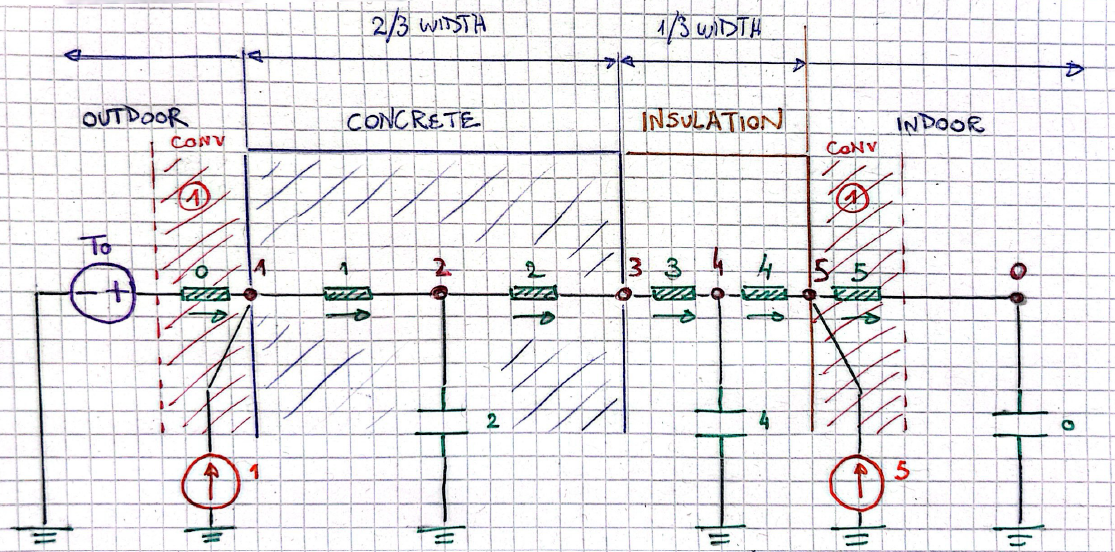

The wall dimensions are:

In [8]:
# Wall dimensions:
thickness = 475 # mm
thickness = thickness/1000 # convert from mm to m
concrete_thickness = thickness *2/3
insulation_thickness = thickness /3
north_length = 11.5 # m
south_length = north_length
east_length = 10 # m
west_length = east_length
height = 3.2 # m

## Windows

The windows are modeled as a volume without heat capacity. This simplifies the simulation. 

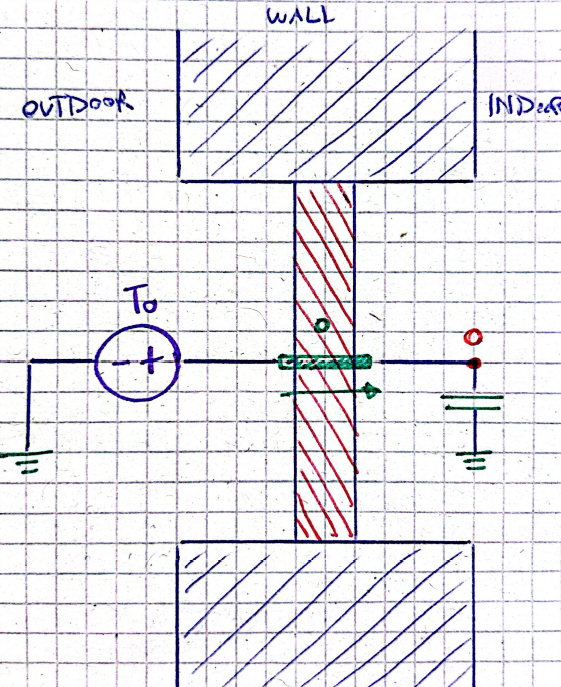

In [9]:
# Window surface and number of windows:
surf_window = 0.8 **2 # m^2
surfaces = {"windows":surf_window}
window_thickness = 2* insulation_thickness
windows_north = 6
windows_south = windows_north
windows_east = 4
windows_west = windows_east

## Roof

The roof is modelled in a similar manner as the walls. The solar radiation, however, does not hit the roof outdoor surface, instead it hits the solar panels. The convection coefficient of the outdoor surface is 4/5 if the walls outdoor, because the panels afect the heat exchange.

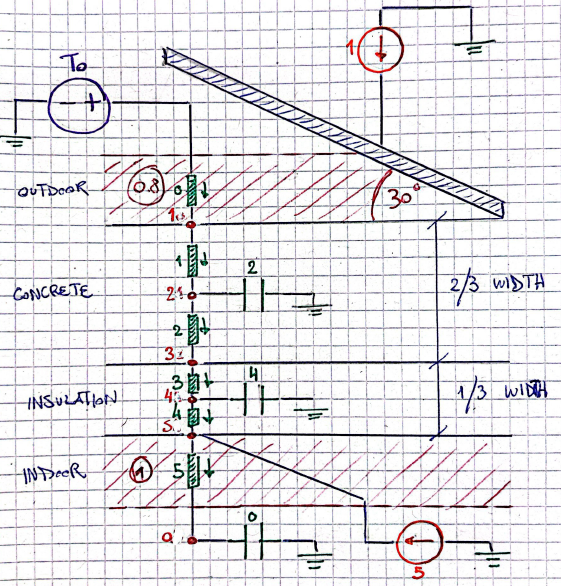

## Other considerations

The model also considers the ventilation of the building and the electronic devices, that in this case are the transformers isolated by gas which are inside the building, and have a strong influence in the temperature of the inside.

## Final model version

The final scheme of the model is shown below.

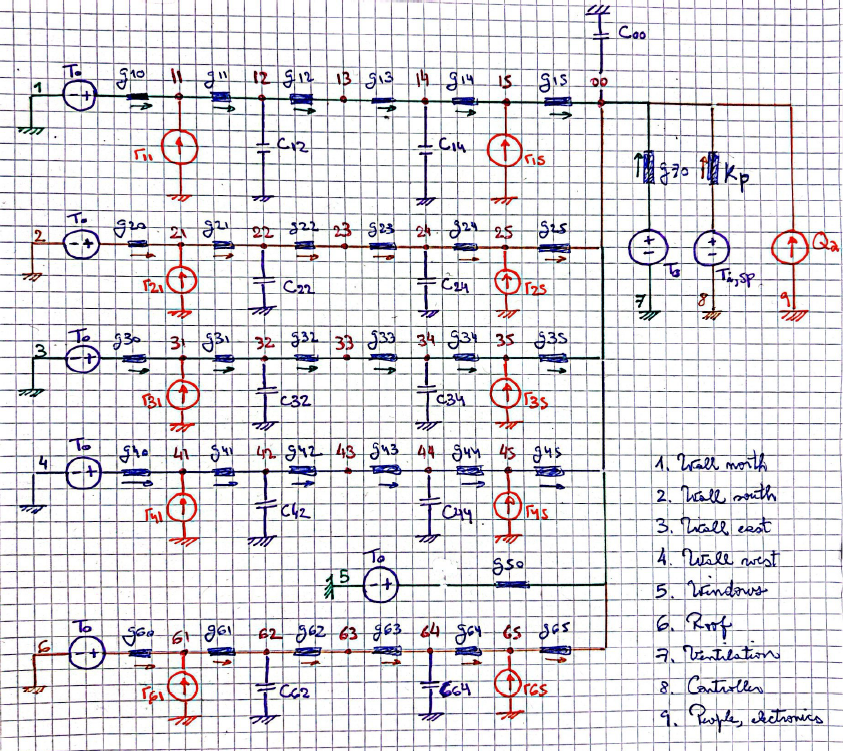

# Calculation of the conductances

The first step for the calculation of the conductances are the relative conductance of the concrete and of the insulation material.

In [10]:
g_concrete = concrete["Conductivity"] / concrete_thickness
g_insulation = insulation["Conductivity"] / insulation_thickness
print(f"The conductance of the concrete is: {g_concrete:.2f} W/K·m⁻².")
print(f"The conductance of the insulation is: {g_insulation:.2f} W/K·m⁻²")

The conductance of the concrete is: 4.42 W/K·m⁻².
The conductance of the insulation is: 0.25 W/K·m⁻²


## Conductance of the walls

From each wall, it is needed its surface (obtained from the wall dimensions) and the conductances between nodes, following the **model**.

### Northern wall 

In [11]:
surf_north = north_length * height - windows_north * surf_window # m^2
surfaces["north"] = surf_north
g10 = ho * surf_north              # W/K (convection)
g11 = g_concrete   * surf_north /2 # W/K (conduction)
g12 = g_concrete   * surf_north /2 # W/K (conduction)
g13 = g_insulation * surf_north /2 # W/K (conduction)
g14 = g_insulation * surf_north /2 # W/K (conduction)
g15 = hi * surf_north              # W/K (convection)

### Southern wall

In [12]:
surf_south = south_length * height - windows_south * surf_window # m^2
surfaces["south"] = surf_south
g20 = ho * surf_south              # W/K (convection)
g21 = g_concrete   * surf_south /2 # W/K (conduction)
g22 = g_concrete   * surf_south /2 # W/K (conduction)
g23 = g_insulation * surf_south /2 # W/K (conduction)
g24 = g_insulation * surf_south /2 # W/K (conduction)
g25 = hi * surf_south              # W/K (convection)

### Eastern wall

In [13]:
surf_east = east_length * height - windows_east * surf_window # m^2
surfaces["east"] = surf_east
g30 = ho * surf_east              # W/K (convection)
g31 = g_concrete   * surf_east /2 # W/K (conduction)
g32 = g_concrete   * surf_east /2 # W/K (conduction)
g33 = g_insulation * surf_east /2 # W/K (conduction)
g34 = g_insulation * surf_east /2 # W/K (conduction)
g35 = hi * surf_east              # W/K (convection)

### Western wall

In [14]:
surf_west = west_length * height - windows_west * surf_window # m^2
surfaces["west"] = surf_west
g40 = ho * surf_west              # W/K (convection)
g41 = g_concrete   * surf_west /2 # W/K (conduction)
g42 = g_concrete   * surf_west /2 # W/K (conduction)
g43 = g_insulation * surf_west /2 # W/K (conduction)
g44 = g_insulation * surf_west /2 # W/K (conduction)
g45 = hi * surf_west              # W/K (convection)

## Windows

The conductances of the windows are simulated all together in one branch, without heat capacity, to simplify the simulation process. Only one node is calculated. The heat transport is made by conduction.

In [15]:
total_windows = windows_north + windows_south + windows_east + windows_west
g50 = total_windows * (glass["Conductivity"] * surfaces["windows"] / window_thickness)

## Roof

The roof of the substation is calculated its conductance in a very similar way as the walls. The roof surface is given by the dimensions of the walls. The roof thickness is the same as the walls thickness. 

In [16]:
surf_roof = north_length * east_length # m^2
surfaces["roof"] = surf_roof
g60 = hroof * surf_roof           # W/K (convection)
g61 = g_concrete   * surf_roof /2 # W/K (conduction)
g62 = g_concrete   * surf_roof /2 # W/K (conduction)
g63 = g_insulation * surf_roof /2 # W/K (conduction)
g64 = g_insulation * surf_roof /2 # W/K (conduction)
g65 = hi * surf_roof              # W/K (convection)

## Ventilation: heat exchange due to advection

Ventilation is modelled as a single **advective branch** that exchanges indoor air with outdoor air. The air change rate is specified by an air-change per hour (ACH) coefficient of 1.5 volumes of air per hour. This factor is assumed due to tilted windows, with the venetian blind closed.

In [17]:
volume = surf_roof * height    # m³, volume of air, ventilation flow rate
ACH = 1.5                      # 1.5/h, tilted window, venetian blind closed
Va_dot = ACH / 3600 * volume   # m³/s, air infiltration
g70 = air['Density'] * air['Specific heat'] * Va_dot # W/K (advection)

# Calculation of the heat capacities

Thermal capacities are assigned to the solid layers and to the zone air. Capacities are computed per node, proportional to the material density, specific heat capacity and volume associated with that node, following the model sketch provided.

In [18]:
c_concrete = concrete["Density"] * concrete["Specific heat"] * concrete_thickness
c_insulation = insulation["Density"] * insulation["Specific heat"] * insulation_thickness

"Inside the room"
c00 = air['Density'] * air['Specific heat'] * volume # J/K (capacity)

"Northern Wall"
c12 = c_concrete * surf_north
c14 = c_insulation * surf_north

"Southern Wall"
c22 = c_concrete * surf_south
c24 = c_insulation * surf_south

"Eastern Wall"
c32 = c_concrete * surf_east
c34 = c_insulation * surf_east

"Western Wall"
c42 = c_concrete * surf_west
c44 = c_insulation * surf_west

"Windows"
c50 = 0

"Roof"
c62 = c_concrete * surf_roof
c64 = c_insulation * surf_roof

# Thermal circuit

The thermal circuit is defined by the standard `dm4bem` tuple:

\[
TC = \{A, G, C, b, f, y\}
\]

where:

- `A` is the incidence matrix between branches (heat flows) and nodes (temperatures),
- `G` is the vector of conductances [W/K],
- `C` is the vector of capacities [J/K],
- `b` is the vector of temperature sources attached to branches,
- `f` is the vector of flow-rate sources attached to nodes,
- `y` indicates which node temperatures are outputs.

We construct these objects explicitly, following the numbering used in the project script. The constructiion of this circuit is done in the function `thermal_circuit` and will be executed every time with different boundary conditions for each simulation.

For this specific model, each part of the Thermal Circuit is defined as it follows:

## Nodes

Temperature nodes are labelled:

- `11, 12, 13, 14, 15` – northern wall,
- `21, 22, 23, 24, 25` – southern wall,
- `31, 32, 33, 34, 35` – eastern wall,
- `41, 42, 43, 44, 45` – western wall,
- `61, 62, 63, 64, 65` – roof,
- `00`                 – indoor air.

## Flow branches

Flow branches represent heat flows:

- convection to ambient: these are all the flow branches between the temperature sources T0 and the nodes of the outdoor wall surface (`q10`, `q20`, `q30`, `q40`).
- conduction between layers (`q11`, `q12`, …),
- window conduction (`q50`),
- roof conduction/convection (`q60…q65`),
- ventilation/advective exchange (`q70`),
- HVAC/control branch (`q80`, with conductance `Kp`).

## Matrix A (incidence matrix)

The incidence matrix `A` has one row per branch and one column per node. Elements are:

- `+1` if the branch flow **enters** the node,
- `−1` if the branch flow **leaves** the node,
- `0` otherwise.

This encodes the network topology.

## Matrix G (conductances)

`G` contains the thermal conductances [W/K] associated with each branch. It also contains `Kp`, that represents the temperature controller of the building. For this first stage, we define it in `Kp = 0`.

## Matrix C (capacities)

`C` contains the heat capacities [J/K] associated with each temperature node.

## Vector b (temperature sources on branches)

`b` attaches temperature sources (Dirichlet boundary conditions) to branches, expressed as *names* of time series (e.g. `To`, `Ti_sp`) that will later be provided in the input data set.

## Vector flow_sources (f): flow-rate sources on nodes

`flow_sources` (named `f` in the thermal circuit) contains *names* of heat-flow sources attached to nodes, such as solar radiation absorbed by surfaces and internal gains `Qa`.

## Output selector (y)

`y` is a vector that selects which node temperatures are considered outputs. Here, we are primarily interested in the indoor air temperature θᵢ at node `00`.

# Boundary conditions

The main boundary conditions for the simulations are:

- `To(t)` – **outdoor air temperature** [°C], from weather data or fixed values;
- `Ti_sp(t)` – **indoor air temperature setpoint** [°C], for the controller;
- `Kp` – **proportional gain** of the HVAC controller [W/K], relating the heat flow to the error `(Ti_sp − Ti)`;
- `Qa(t)` – **internal heat gains** [W] from machines and auxiliary loads;
- `r..(t)` – **short-wave solar radiation** absorbed at external and internal surfaces [W].

In the thermal circuit, temperature boundary conditions are introduced through the vector `b` (branches with temperature sources), while heat-flow boundary conditions (solar gains and internal gains) are introduced through the vector `f` (nodes with flow sources). :contentReference[oaicite:4]{index=4}

For each simulation scenario we specify:

- constant or time-dependent `To`, `Ti_sp`, and `Qa`;
- solar radiation components `r11…r61` (external surfaces) and `r15…r65` (internal surfaces);
- the proportional gain `Kp` (often set to 0 in this project to focus on passive behaviour).

# Steady state and step response

We first convert the thermal circuit into a state-space model using `dm4bem.tc2ss(TC)`:

$$
\dot{\theta}(t) = A_s \theta(t) + B_s u(t) \\
y(t) = C_s \theta(t) + D_s u(t)
$$

where:

- `θ` are state temperatures (nodes with capacities),
- `u` is the input vector (boundary conditions and sources),
- `y` are the outputs (here, indoor air temperature).

From the eigenvalues of `A`, we obtain:

- the **maximum stable time step** for explicit Euler: $\Delta t_{\max} = 2 \min_i\left(-\frac{1}{\lambda_i}\right)$
- the **settling time**: $t_{\text{settle}} \approx 4 \max_i\left(-\frac{1}{\lambda_i}\right)$


In [19]:
"Boundary Conditions"
T0 = 10               # °C, Temperature outside
Ti_sp = 0             # °C, Temperature inside, set by the user
Kp = 0                # W/K, temperature controller
f_90 = 0              # flow sources inside the room, like machines and people, in W
TC = mtt.thermal_circuit(g10,g11,g12,g13,g14,g15,g20,g21,g22,g23,g24,g25,g30,g31,g32,g33,g34,g35,g40,g41,g42,g43,g44,g45,g50,g60,g61,g62,g63,g64,g65,g70,Kp,c12,c14,c22,c24,c32,c34,c42,c44,c62,c64,c00)
delta_tmax, dt, t_settle =  mtt.steady_state(T0, Ti_sp, TC)

Δtmax = 3239 s = 54.0 min
dt = 900 s = 15.0 min
duration = 1252800 s = 348.0 h


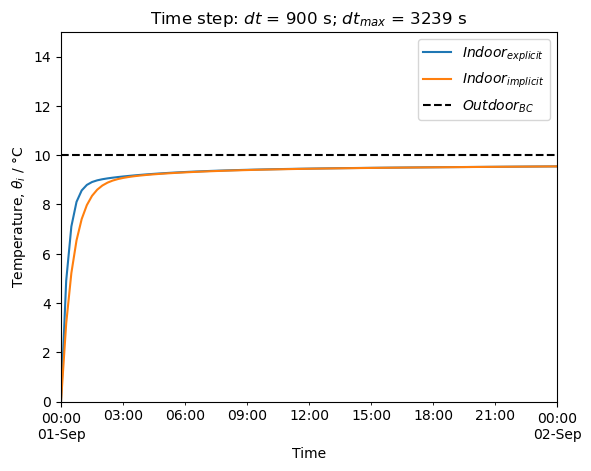

In [20]:
mtt.simulation_steadystate(dt, t_settle, delta_tmax, T0, Ti_sp, f_90, TC, summer=True)
# The end_date can be specified with the format '2025-mm-dd'

Following the `dm4bem` textbook, a numerical time step `dt` smaller than `Δtmax` must be chosen. In this project, even though the stability criterion allows a relatively large `dt = 15.0 min`, the initial choice was still too coarse for numerical comfort, so **a new time step `dt = 150 s` was manually imposed** as a conservative value.

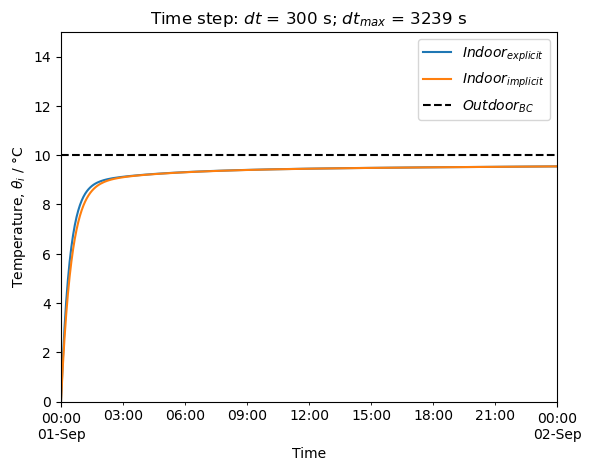

In [21]:
dt = 300 # seconds (5 minutes < 15 min) <--------------------- NEW TIME STEP!
mtt.simulation_steadystate(dt, t_settle, delta_tmax, T0, Ti_sp, f_90, TC, summer=True)
# The end_date can be specified with the format '2025-mm-dd'

Explicit and implicit Euler simulations produce essentially identical indoor temperature responses, confirming both the correct formulation of the thermal circuit and the numerical stability of the chosen time step.

## Simulation with Internal Load Qa (f_90)

Once the time step has been defined, it is of our interest to simulate the Indoor temperature with the internal flow sources. For the substation, the flow sources come mostly from the equipments inside it, that will heat up the room around 2 or 3°C.

The following simulation is run without temperature controller indoor, no solar radiation and outdoor temperature constant given by the Boundary Conditions. It can be seen that the substation increases its temperature by 3 degrees for each megawatt (f_90 = 1000 W) with respect to the constant outdoor temperature. This variable will play an important role for the project.

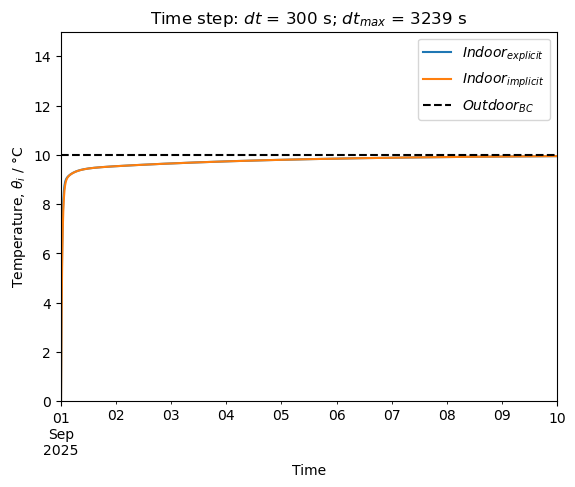

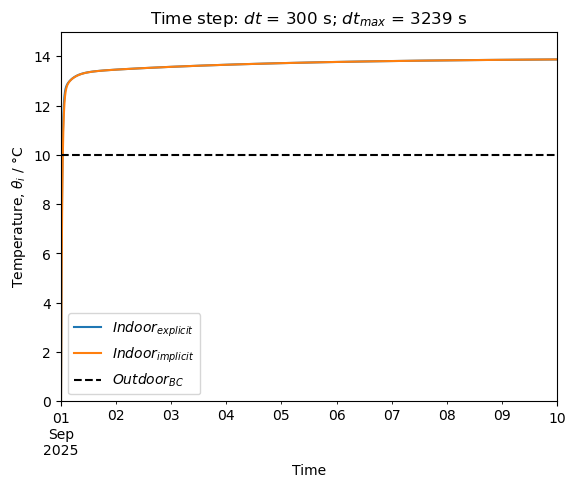

In [22]:
T0 = 10 # °C, Temperature outside
Kp = 0 # W/K, temperature controller
f_90 = 1000 # flow sources inside the room, like machines and people, in W
mtt.simulation_steadystate(dt, t_settle, delta_tmax, T0, Ti_sp, 0, TC, summer=True, end_date='2025-09-10') # f_90 = 0
mtt.simulation_steadystate(dt, t_settle, delta_tmax, T0, Ti_sp, f_90, TC, summer=True, end_date='2025-09-10') # f_90 = 1000

## Simulation with Dynamic Conditions

Before simulating, the meteorological year (TMY) weather data for Dübendorf, Switzerland, is imported from an EPW file. The relevant information for this project is in the following columns:

- `temp_air` – dry-bulb air temperature [°C],
- `dir_n_rad` – direct normal solar radiation [Wh/m²],
- `dif_h_rad` – diffuse horizontal solar radiation [Wh/m²].

Example weather record:
temp_air      28.0
dir_n_rad    802.0
dif_h_rad    158.0
Name: 2025-06-29 12:00:00+01:00, dtype: float64


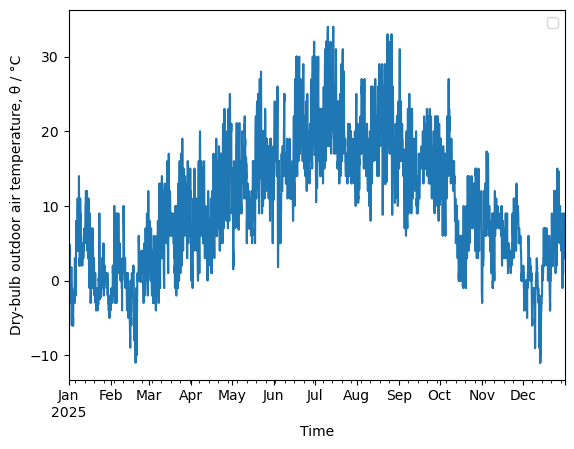

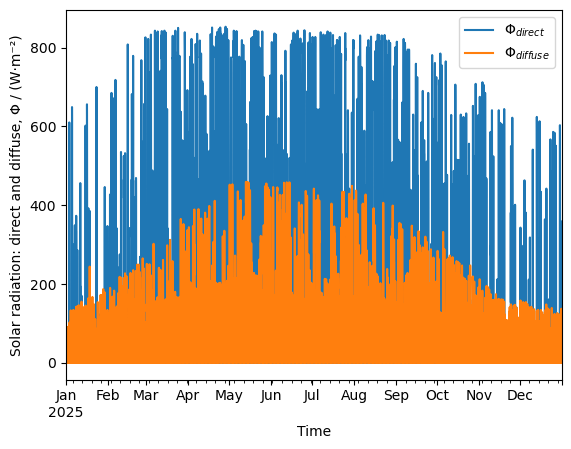

In [23]:
weather_data = mtt.weather_of_dubendorf()

Now the dynamic simulation can be started. At the top, the boundary conditions are defined. **This section is intended to be "free to play".** At the Discussion section, each of the simulations done for the project are explained, with boundary conditions specified and conclusions done along them.


## Scenario 1: Simple simulation with weather conditions

For the very first dynamic simulation, the model is run with variable outdoor temperature, provided by the weather data. The temperature controller is not going to work, no internal load is present and the radiation does not play a role. The simulation is run in both summer and winter. The initial condition for the outdoor temperature can be controlled with the boundary condition T0.

The behaviour expected is that the temperature indoor follows the outdoor temperature during all the simulation period, as no other factor is included. The energy consumption will be 0 because the temperature controller is off.

Simulation in Summer:


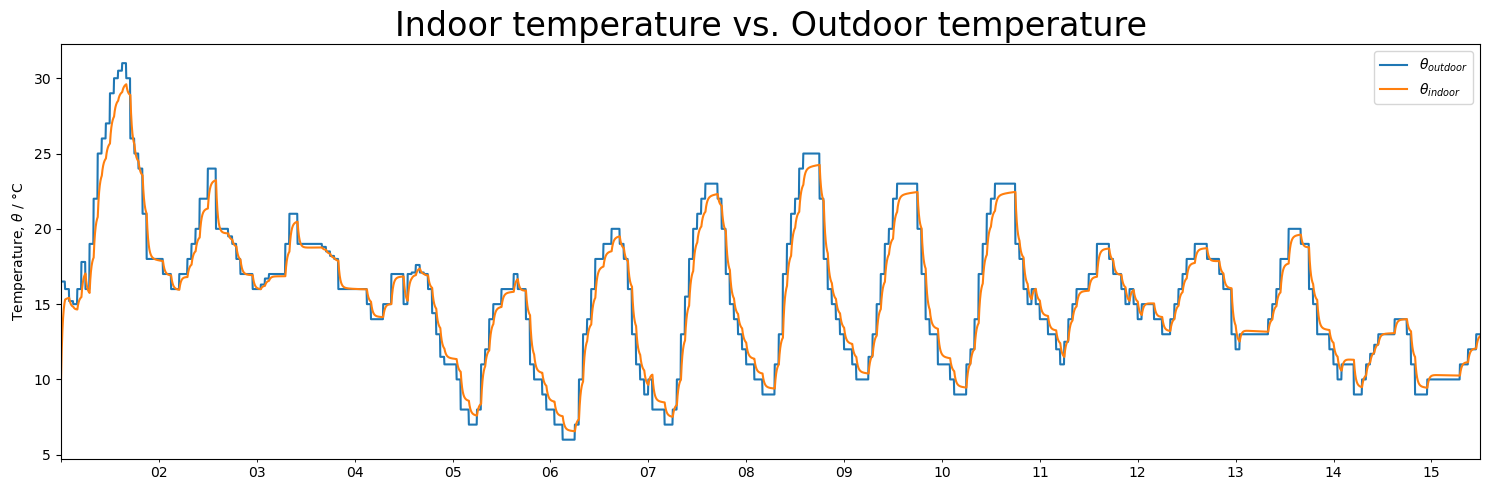

Min. indoor temperature: 6.5575 °C
Max. indoor temperature: 29.5991 °C
Max. load: -0.0 W/m² at 2025-09-01 00:00:00+01:00
Energy consumption: 0.0 kWh
------------------------------------------------------------
Simulation in Winter


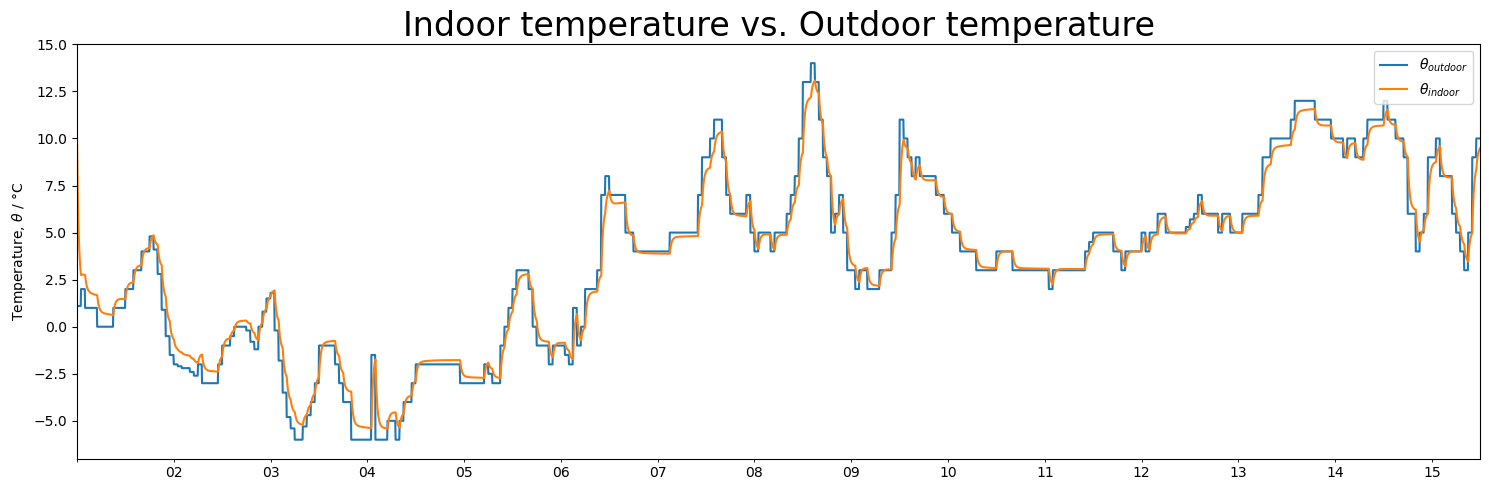

Min. indoor temperature: -5.4085 °C
Max. indoor temperature: 13.0790 °C
Max. load: -0.0 W/m² at 2025-01-01 00:00:00+01:00
Energy consumption: 0.0 kWh


In [24]:
"Boundary Conditions"
T0 = 10.0 # as mode == temperature, this represents only the initial condition.
Ti_sp = 0
Kp = 0
f_90 = 0
plot_radiations = False
mode = 'temperature' # T0 = T0(t) from the weather data but radiation = 0

summer = True # if True, simulation is in September. If false, it is in January.
print("Simulation in Summer:")
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)
print("------------------------------------------------------------")

summer = False
print("Simulation in Winter")
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

## Scenario 2: Simple simulation with solar radiation

In the second case, the model is simulated only with solar radiation. The outdoor temperature remains constant, and it is given by the boundary conditions set in the beginning. The temperature controller Kp and the internal load f_90 are again zero. The energy consumption of the substation must be 0. The simulation is run in both summer and winter.

The solar radiation is provided from the weather data, and computed on:
- each wall, considering that the normal of each one is parallel to the coordinate system (defined by the Compass Rose),
- the roof, considering that it is completely hidden under the solar panels at all times,
- the solar panels, considering that they have an inclination of 30 degrees in the East-West direction.

The solar radiation is cathegorized in:
- `direct`   – direct component on the tilted surface [Wh/m²],
- `diffuse`  – diffuse component on the surface [Wh/m²],
- `reflected`– ground-reflected component on the surface [Wh/m²].

It is expected that the temperature indoor increases during the day and tends to the temperature T0 during the nights. The user can freely adjust the temperature T0 by modifying the Boundary Conditions. The temperature difference between day and night is expected to be higher in summer than in winter, because the solar radiation during summer is stronger.

For this scenario, the solar radiations are also shown with the option `plot_radiations = True`.


Simulation in Summer:


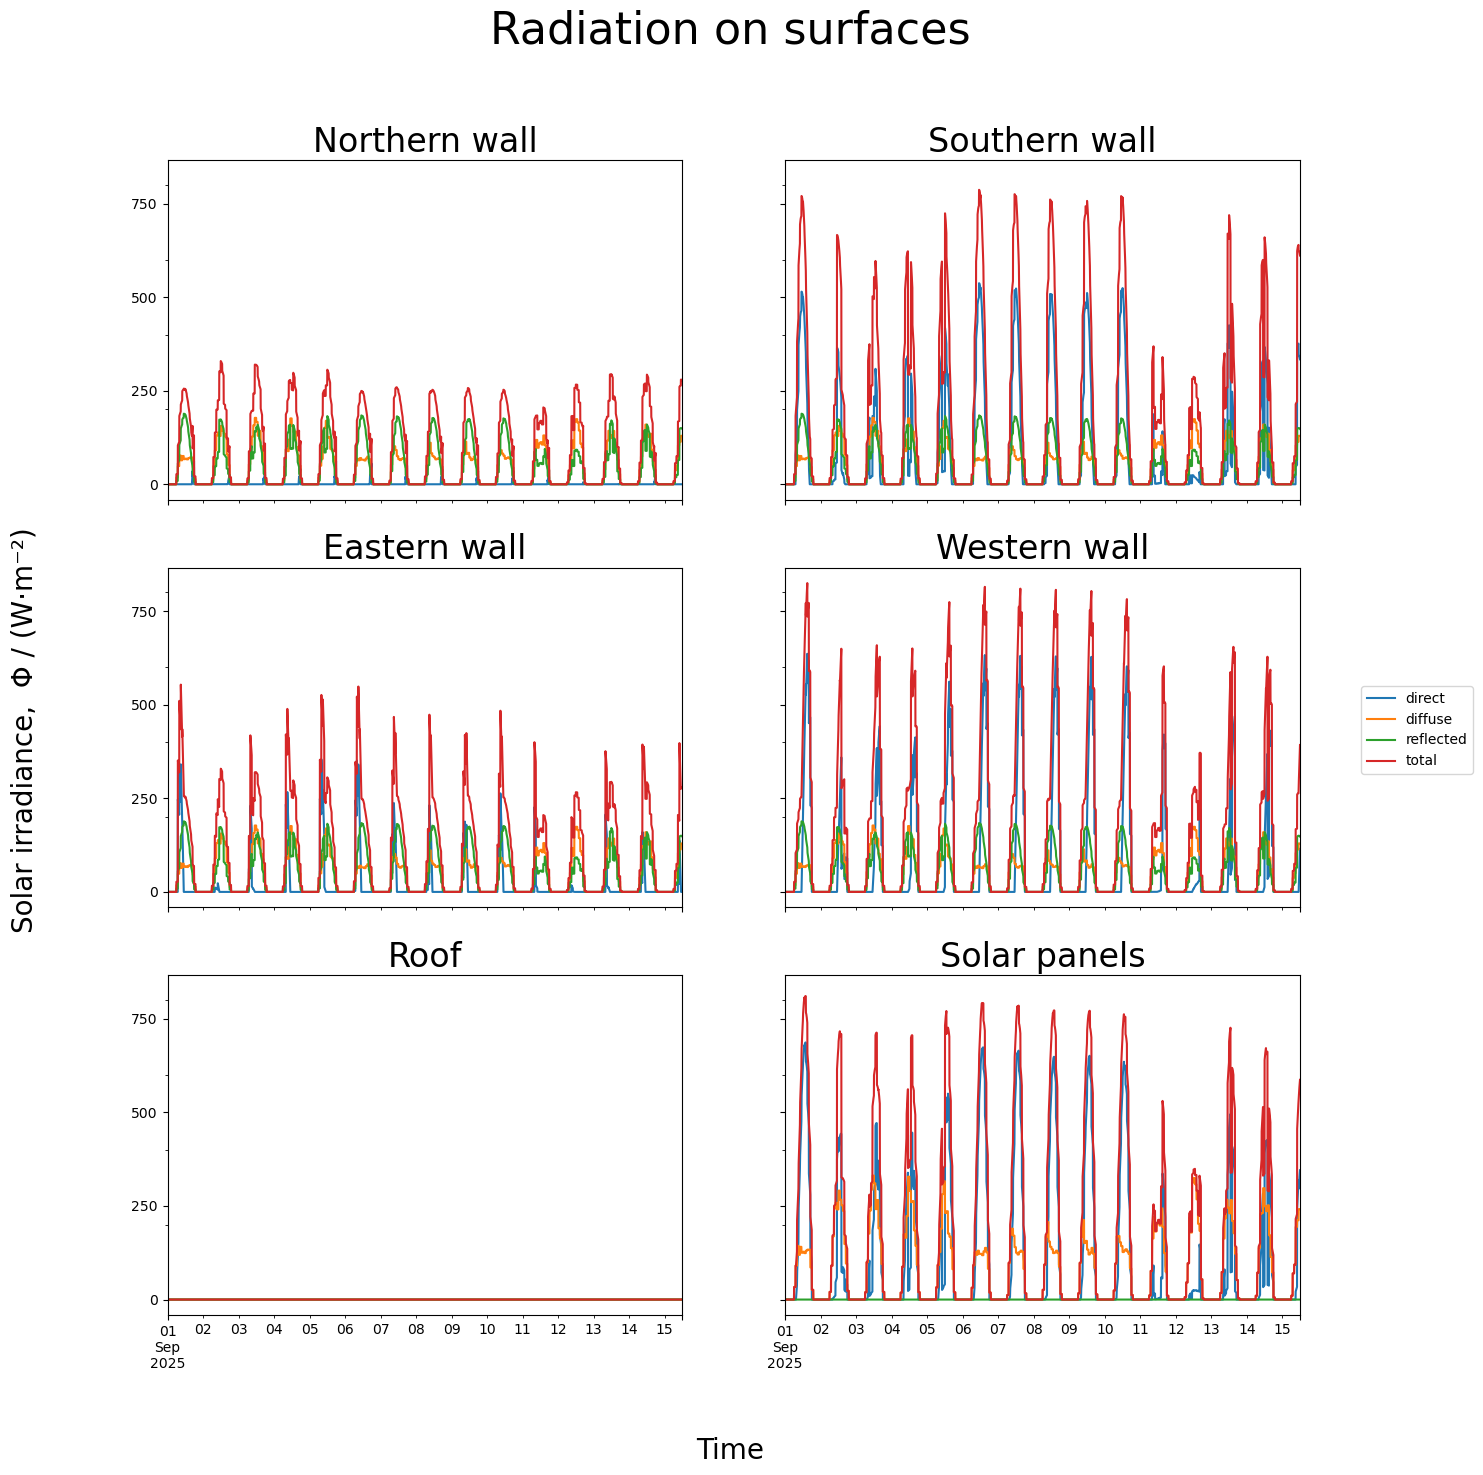

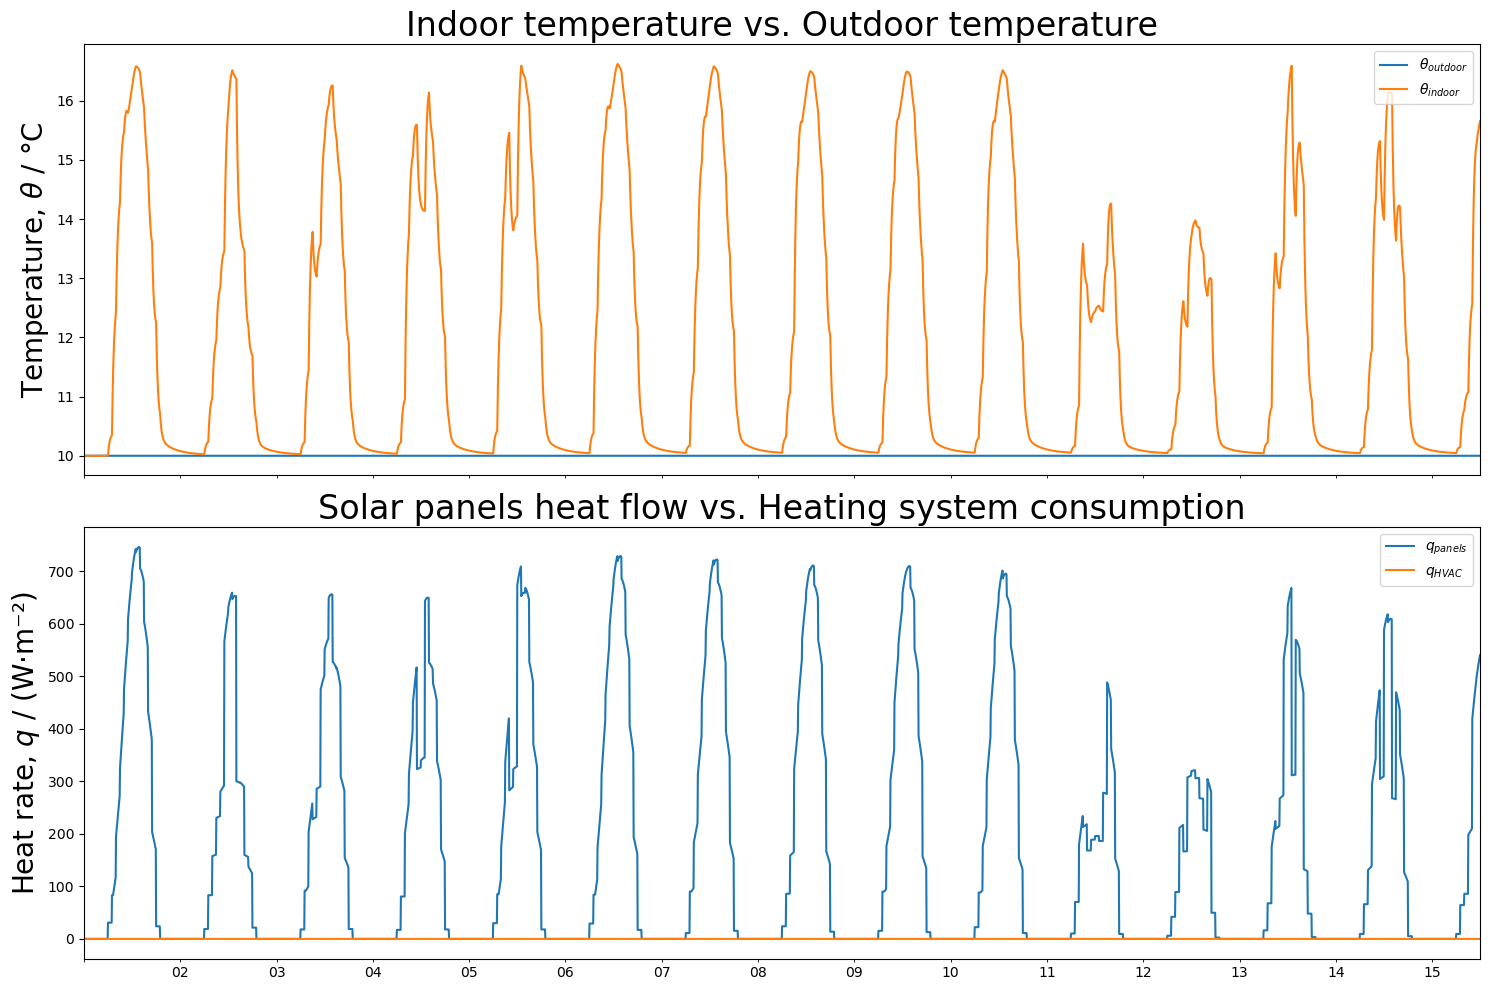

Min. indoor temperature: 10.0000 °C
Max. indoor temperature: 16.6240 °C
Max. load: -0.0 W/m² at 2025-09-01 00:00:00+01:00
Energy consumption: 0.0 kWh
Max. load panels: 0.7 kW at 2025-09-01 13:40:00+01:00
Energy production of the solar panels: 59.2 kWh
------------------------------------------------------------
Simulation in Winter


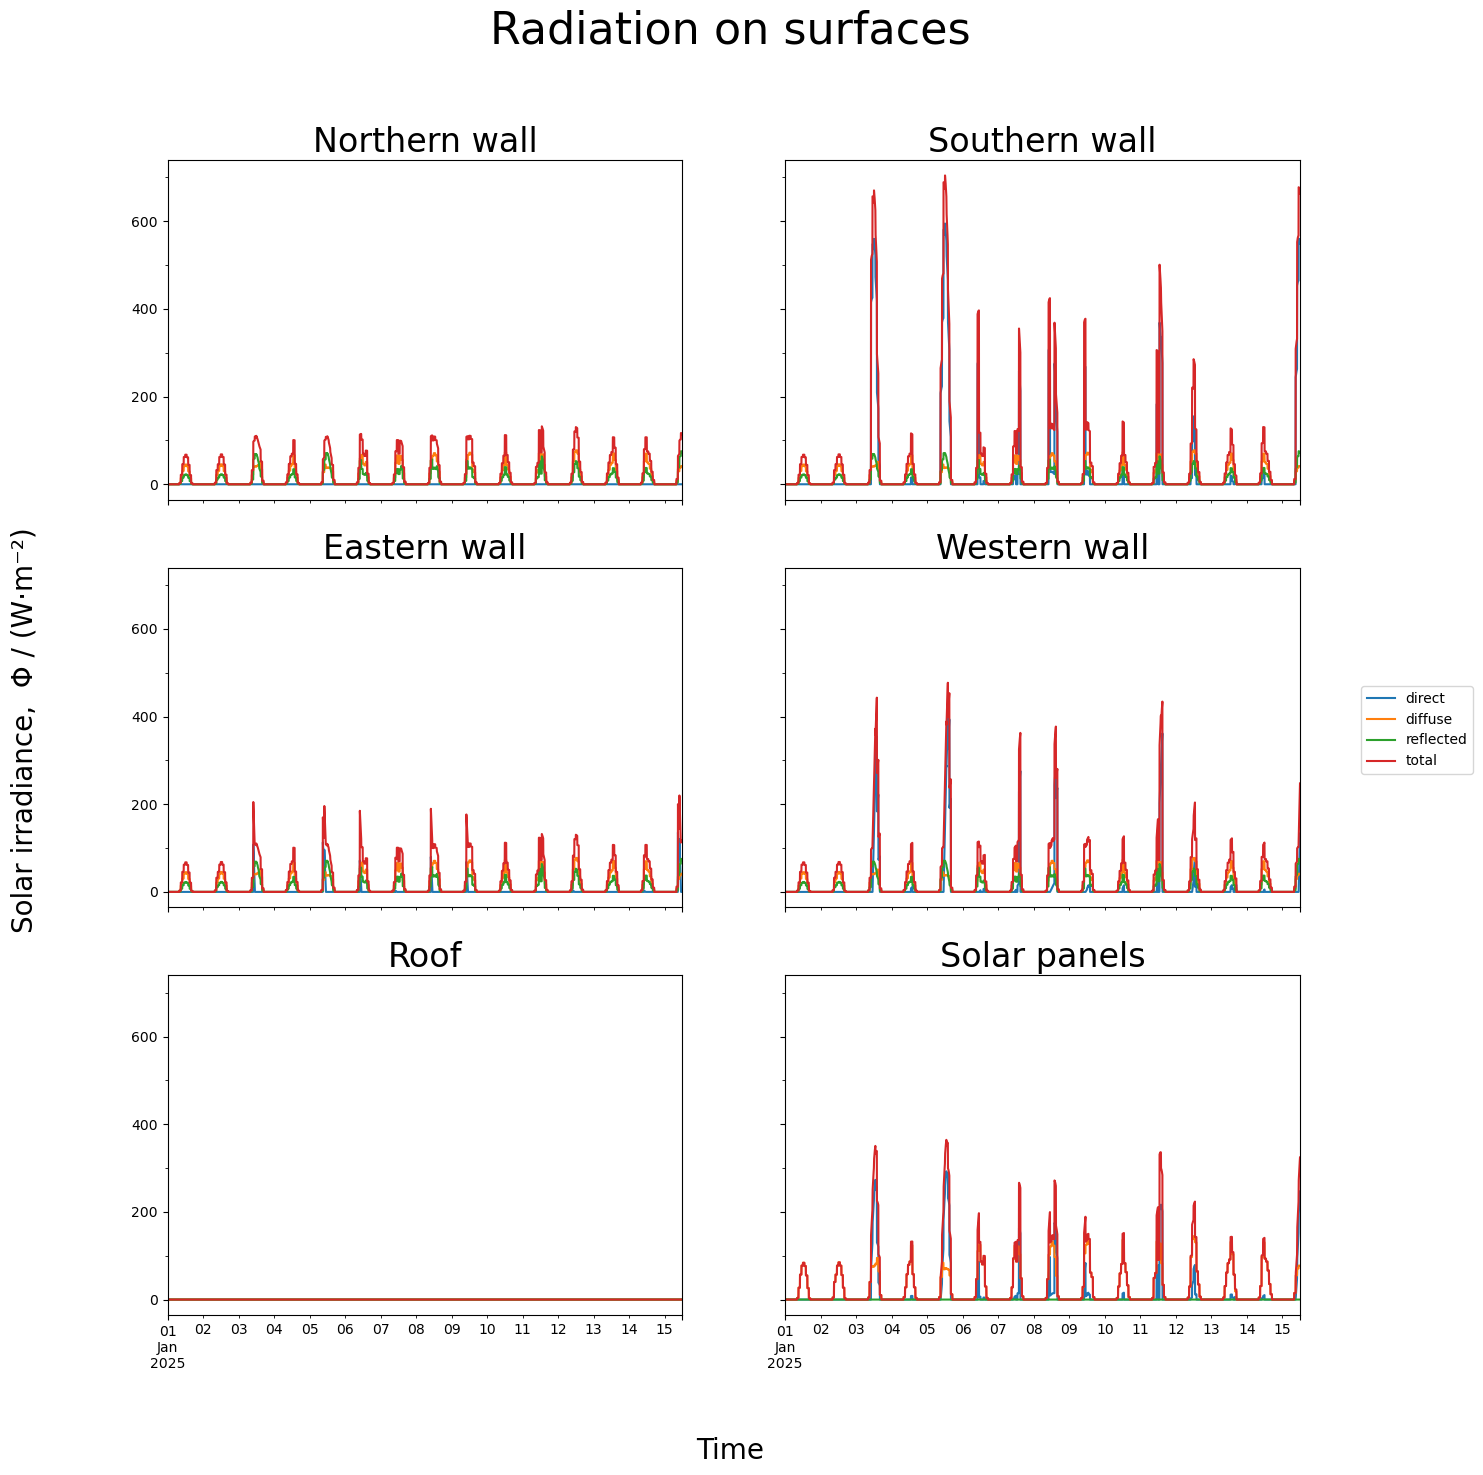

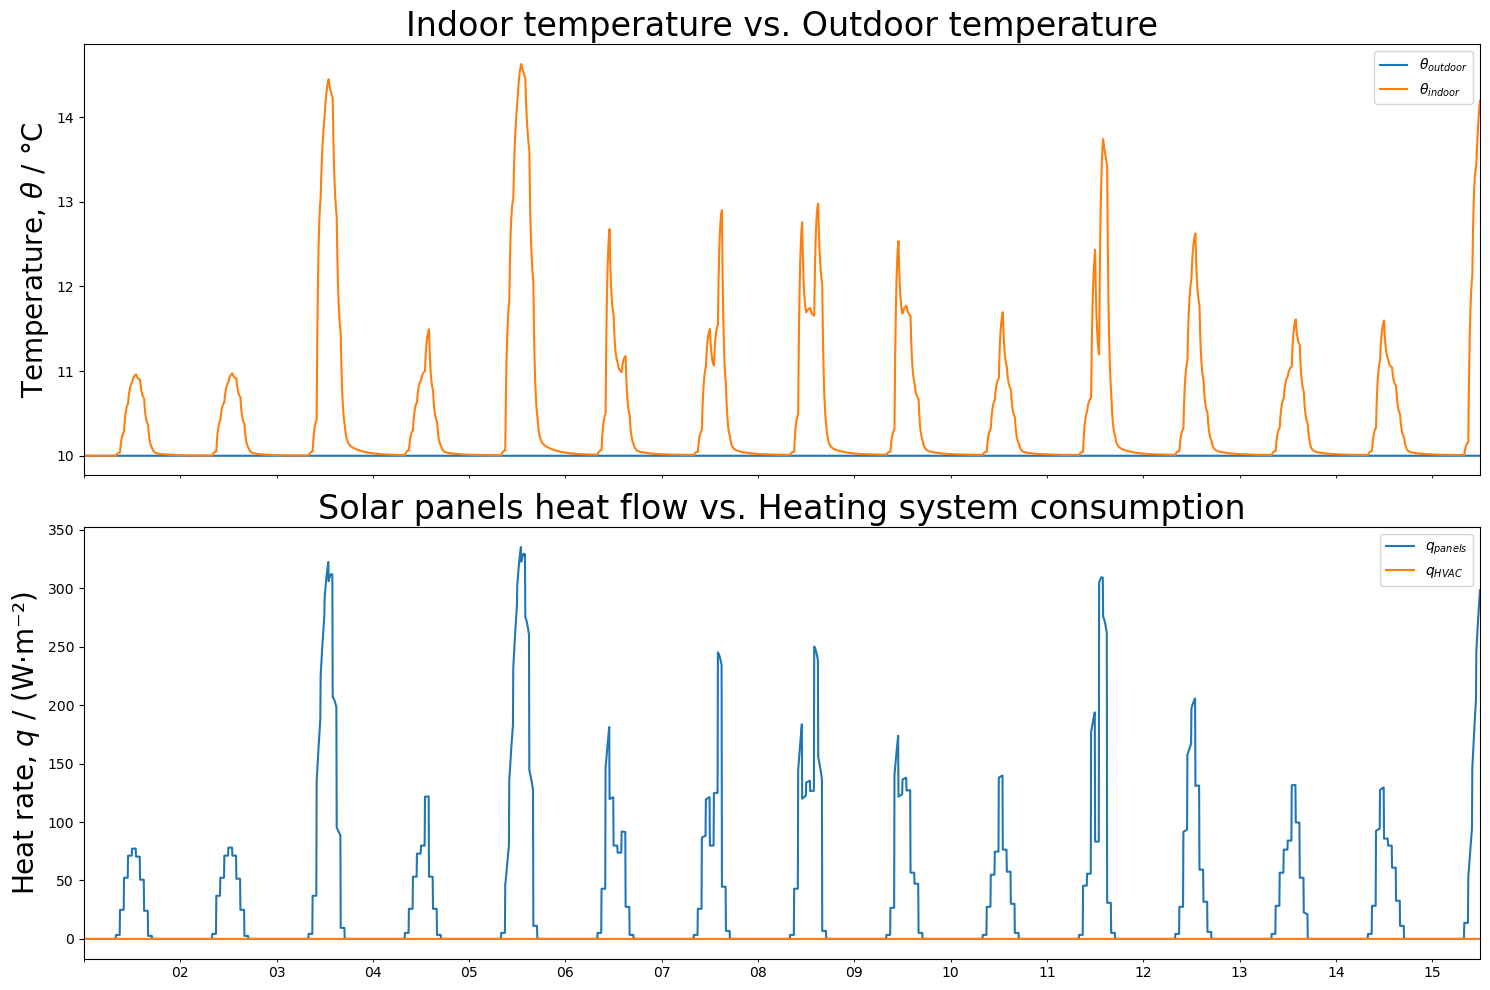

Min. indoor temperature: 10.0000 °C
Max. indoor temperature: 14.6290 °C
Max. load: -0.0 W/m² at 2025-01-01 00:00:00+01:00
Energy consumption: 0.0 kWh
Max. load panels: 0.3 kW at 2025-01-05 12:55:00+01:00
Energy production of the solar panels: 11.0 kWh


In [25]:
"Boundary Conditions"
T0 = 10.0 # <----------------- adjust this value to own criteria
Ti_sp = 0
Kp = 0
f_90 = 0
plot_radiations = True
mode = 'radiation' # only radiation is simulated with T0 from boundary conditions.

summer = True # if True, simulation is in September. If false, it is in January.
print("Simulation in Summer:")
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)
print("------------------------------------------------------------")

summer = False
print("Simulation in Winter")
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

For both summer and winter, the indoor temperature changes along the simulation time, showing how significant the effect of the solar radiation is. During the summer, the maximum temperature difference along the whole simulation period is 6.62 °C, while in winter it is 4.63 °C.

The indoor temperature follows a shape which is directly proportional to the 

For each case, two plots are shown. In the first one, the radiation on the six surfaces is presented as mentioned before. The second one exposes two aspects:
1. **Indoor vs. Outdoor temperature.** Both temperatures are calculated along the simulation period.
2. **Solar panels heat flow vs. Heating system consumption.** The idea is to visualize the percentage of energy consumed by the temperature controller that can be satisfied by the solar panels.

### Discussion: differences between the configurations with or without solar panels.

The solar panels are black bodies that absorve most of the solar radiation. The short wave absortivity coefficient is usually between 0.90 and 0.95, while the one of the concrete is around 0.20 and 0.30, making it capable to transform more of that solar radiation in heat through the building.

The best configuration is to place the solar panels in a separate field, and to connect them to the heating system. In this way, not only the sun radiation is heating the building through the roof, but the solar panels are providing electrical energy to run the temperature controller. However, this configuration increases the costs, because it is needed a second land of the same size as the roof of the substation. 

With the current configuration, the solar radiation through the roof is not considered, however the solar panels take a larger proportion of the heat than the concrete, and provide more heat than the one that could be delivered through the roof. The current configuration is the most efficient one in terms of cost.

## Scenario 3. Simulation with outdoor temperature & solar radiation.

In this ocassion, both outdoor temperature and solar radiation are simulated. The information is coming from the weather data. No temperature controller or internal load are yet simulated on dynamic conditions. 

The behaviour expected is similar to the scenario 2, but the difference is that the outdoor temperature is now variable.

In summer, the solar radiation increases the indoor temperature around 5 °C for every simulated day, while in winter, there are days where the radiation is not so strong and the indoor temperature does not change so much.

Simulation in Summer:


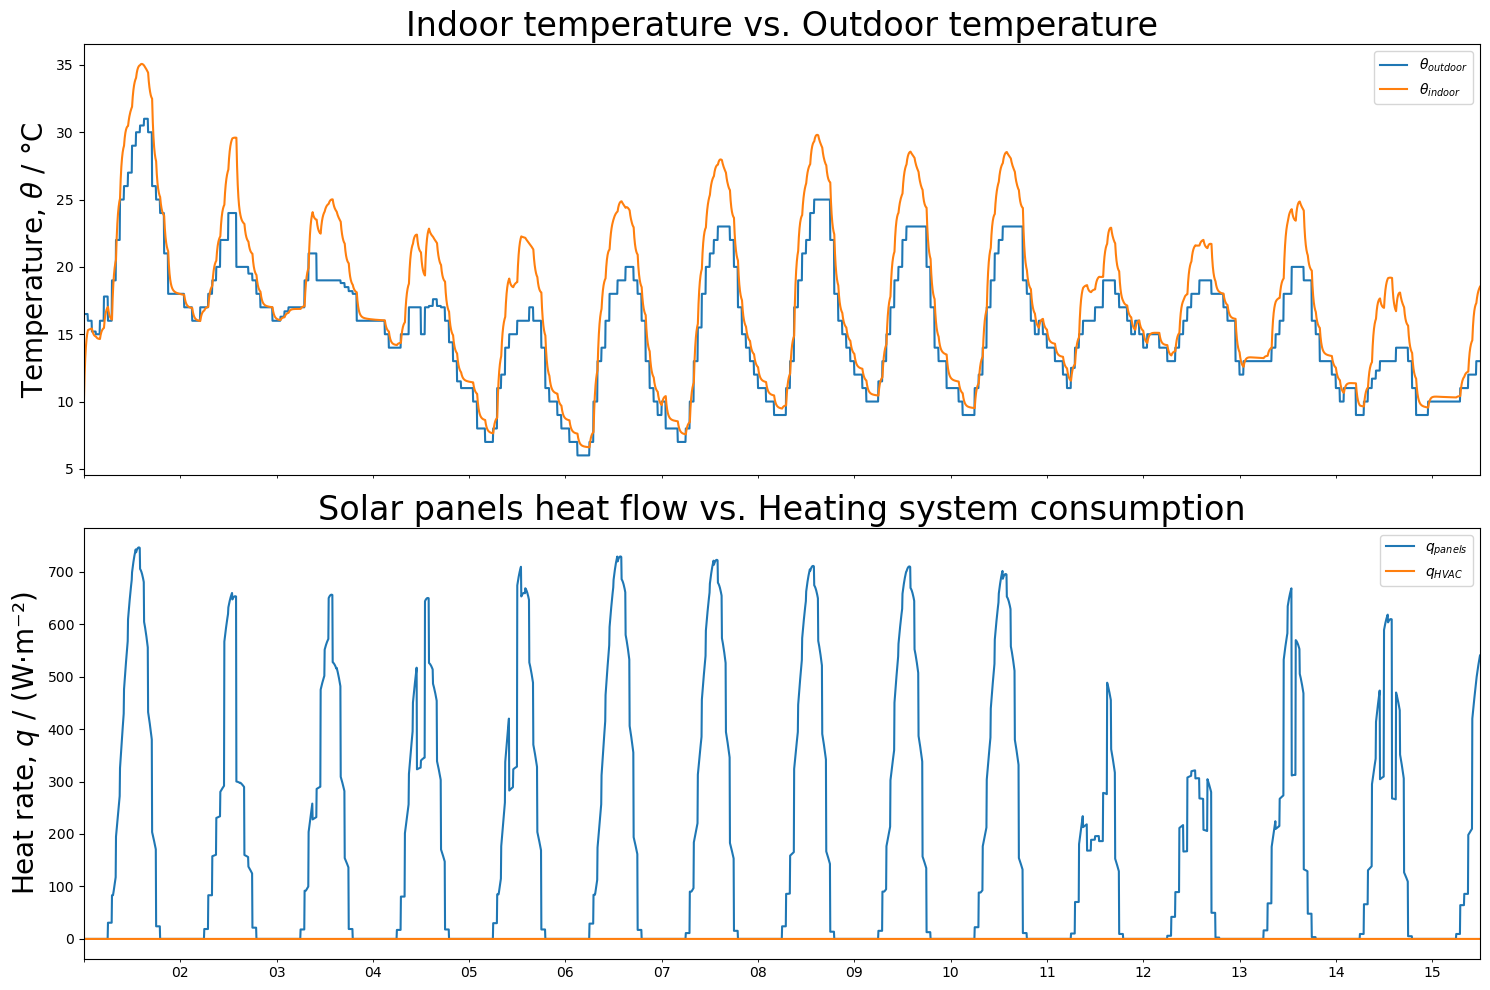

Min. indoor temperature: 6.6015 °C
Max. indoor temperature: 35.0746 °C
Max. load: -0.0 W/m² at 2025-09-01 00:00:00+01:00
Energy consumption: 0.0 kWh
Max. load panels: 0.7 kW at 2025-09-01 13:40:00+01:00
Energy production of the solar panels: 59.2 kWh
------------------------------------------------------------
Simulation in Winter


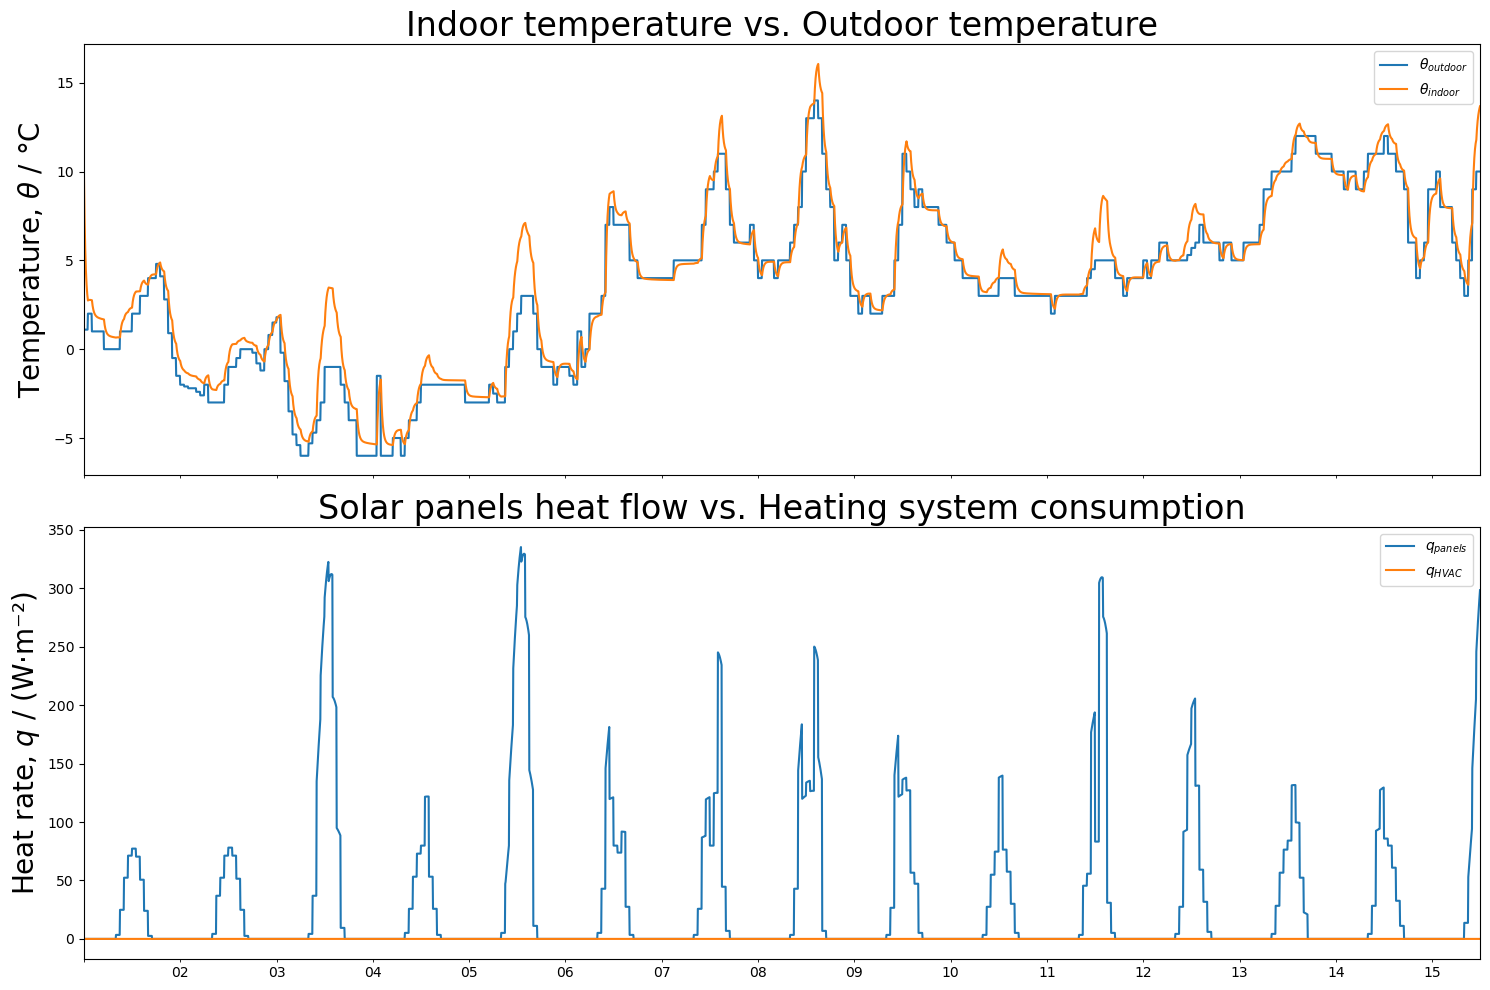

Min. indoor temperature: -5.3967 °C
Max. indoor temperature: 16.0564 °C
Max. load: -0.0 W/m² at 2025-01-01 00:00:00+01:00
Energy consumption: 0.0 kWh
Max. load panels: 0.3 kW at 2025-01-05 12:55:00+01:00
Energy production of the solar panels: 11.0 kWh


In [26]:
"Boundary Conditions"
T0 = 10.0 # this represents only the initial condition.
Ti_sp = 0
Kp = 0
f_90 = 0
plot_radiations = False
mode = 'both' # T0 = T0(t) and radiation != 0.

summer = True # if True, simulation is in September. If false, it is in January.
print("Simulation in Summer:")
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)
print("------------------------------------------------------------")

summer = False
print("Simulation in Winter")
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

## Scenario 4. Dynamic simulation with internal load. 

As seen previously, at the steady state the internal load increases the indoor temperature around 3°C/MW. In this occassion, the same simulation is run under dynamic conditions. It is expected to see the temperature increase the same magnitude along all the simulation period, because it is considered that the machines inside the substation work at steady state, as it happens usually in a substation.

For this scenario, the simulation is run only in summer. No temperature controller is active yet. **This scenario illustrates the worst-case free-floating behaviour: without active control, the combination of solar and internal loads can result in persistent overheating.**

As a consequence of the solar radiation and the internal load combined, the indoor temperature has been increased over 30 °C for many of the days under simulation. This shows that:
- Even moderate continuous internal gains (representing power-electronic equipment) have a non-negligible impact on indoor temperature.
- The temperature rise is limited by the envelope conductances and the large heat capacities: the building behaves as a low-pass filter, smoothing short-term fluctuations in gains and outdoor conditions.

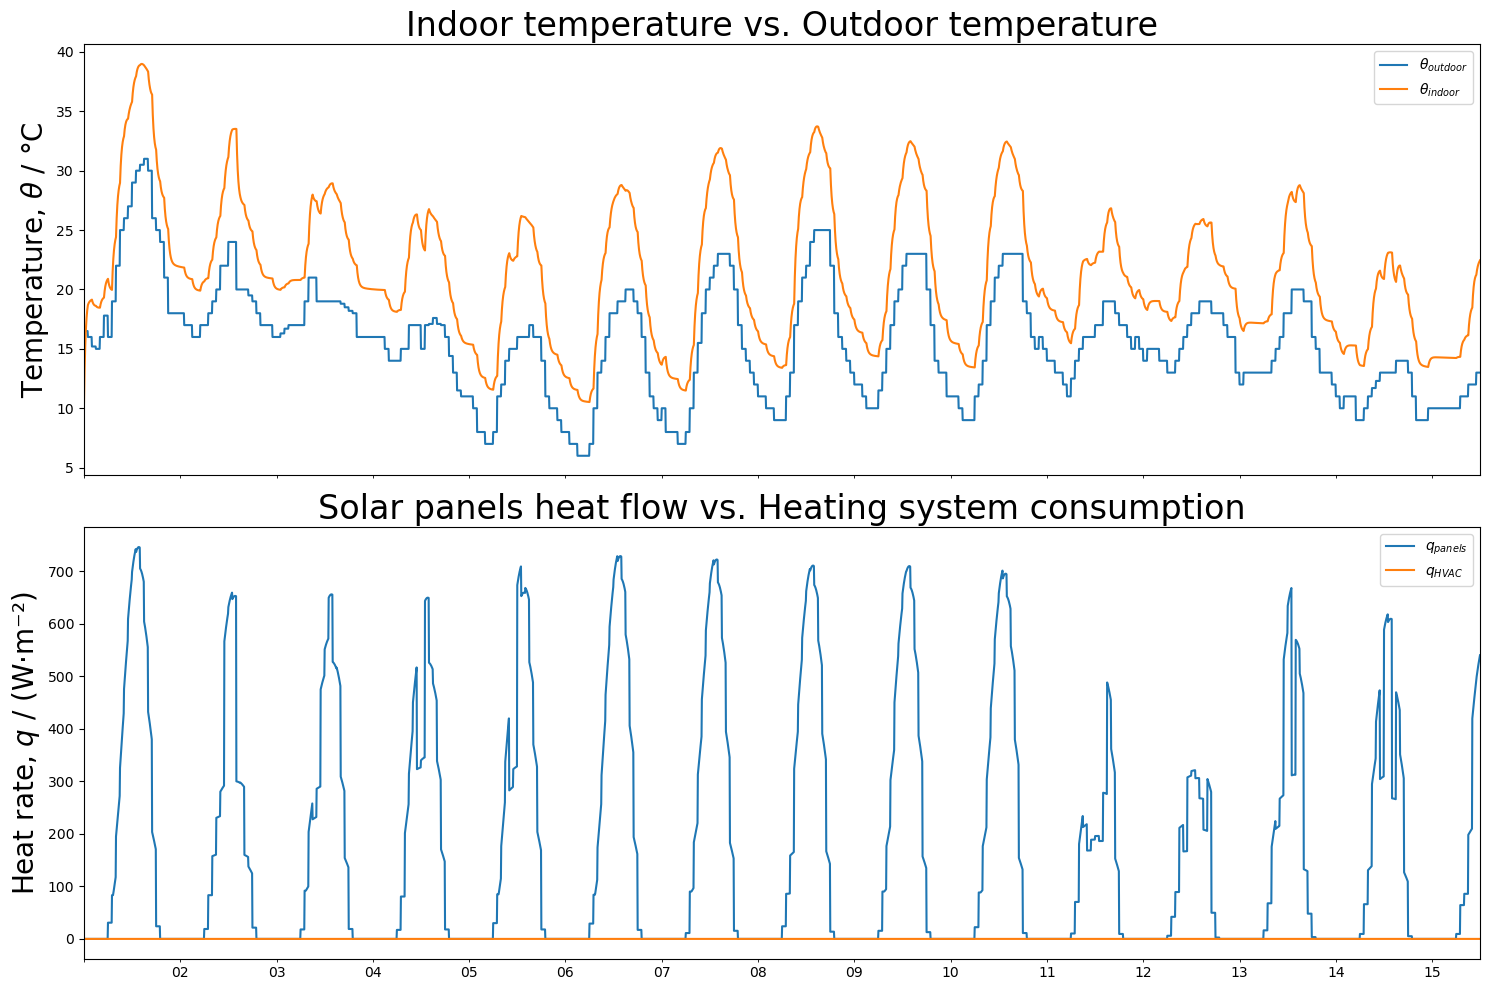

Min. indoor temperature: 10.0000 °C
Max. indoor temperature: 38.9878 °C
Max. load: -0.0 W/m² at 2025-09-01 00:00:00+01:00
Energy consumption: 0.0 kWh
Max. load panels: 0.7 kW at 2025-09-01 13:40:00+01:00
Energy production of the solar panels: 59.2 kWh


In [27]:
"Boundary Conditions"
T0 = 10.0 
Ti_sp = 0
Kp = 0
f_90 = 1000 # <------------------ New parameter
plot_radiations = False
mode = 'both' # T0 = T0(t) and radiation != 0.
summer = True

mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

## Scenario 5. Dynamic simulations with temperature controller.

In the fifth simulation, a temperature controller is now considered. The simulation is organized in different levels, for both Summer and Winter:
1. **Perfect temperature controller.** The main core of this simulation level is to find the minimum Kp for the indoor temperature to remain constant along all the simulation period.
2. **Temperature controller working with solar power.** The temperature controller will only consume solar energy. The Kp will be changed until the integral of each curve of the second subplot are equal, and this will be shown by the text printed after the images, where the energy provided by the solar panels is the 100 % of the energy consumed. The idea is to see how the indoor temperature could be controlled if no external source was considered, for example, in case of an emergency.
3. **Real temperature controller.** The temperature controller will work under normal conditions. With this, it will be shown the real energy consumption of the controlling system, the change in the indoor temperature, and the proportion of the energy that can be satisfied by the solar panels.


### Perfect temperature controller during Summer

During summer, the temperature controller acts a cooling system because the indoor temperature tends to be larger than the temperature of the set point Ti_sp. The constant temperature has not been reached, but it was shown that the indoor temperature tends to be constant. Increasing the Kp forces to reduce the time step `dt` manually. The curve of heat rate is negative because it is extracting energy from inside the building.

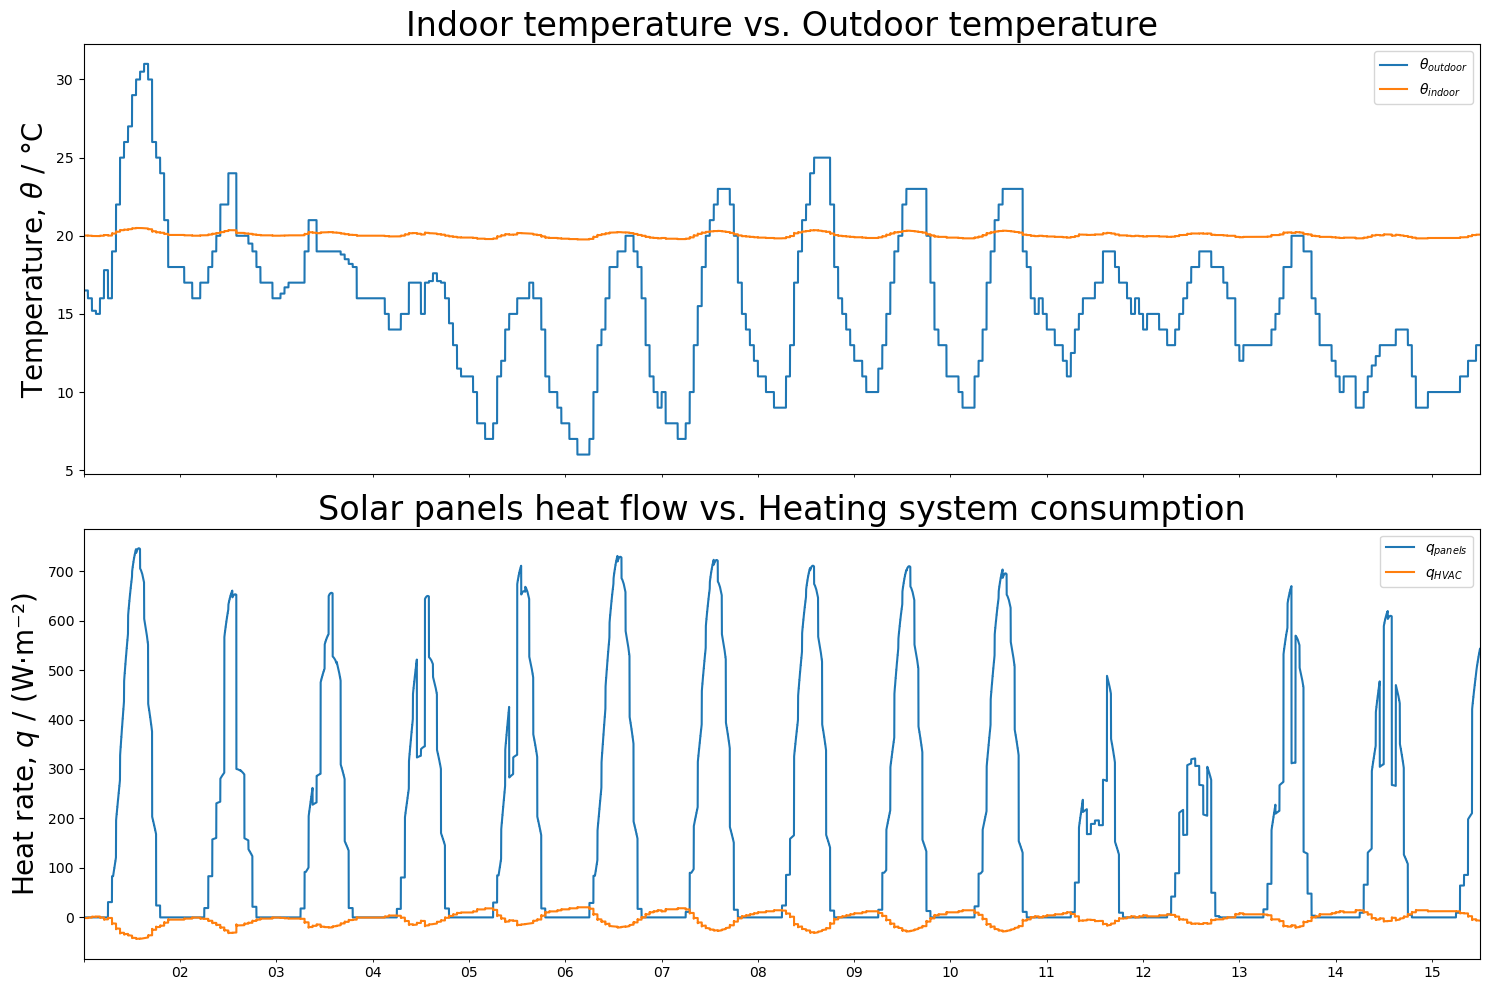

Min. indoor temperature: 19.7619 °C
Max. indoor temperature: 20.5016 °C
Max. load: 20.7 W/m² at 2025-09-06 03:00:50+01:00
Energy consumption: 150.7 kWh
Max. load panels: 0.7 kW at 2025-09-01 13:42:30+01:00
Energy production of the solar panels: 59.2 kWh
Energy covered by the solar panels: 39.29 %


In [28]:
"Boundary Conditions"
T0 = 20.0 
Ti_sp = 20 # <------------------ New parameter
Kp = 10000 # <------------------ New parameter
f_90 = 1000 
plot_radiations = False
mode = 'both'
summer = True

# For large Kp, the time step has to be decreased.
dt = 50 # seconds

# Recalculate the thermal circuit with a new Kp!=0.
TC = mtt.thermal_circuit(g10,g11,g12,g13,g14,g15,g20,g21,g22,g23,g24,g25,g30,g31,g32,g33,g34,g35,g40,g41,g42,g43,g44,g45,g50,g60,g61,g62,g63,g64,g65,g70,Kp,c12,c14,c22,c24,c32,c34,c42,c44,c62,c64,c00)

mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

### Perfect temperature controller during Winter

During the winter, the temperature controller acts as a heating system until the temperature indoor reaches the set point Ti_sp. The curve of heat rate is above the zero line because it is inserting heat into the building.

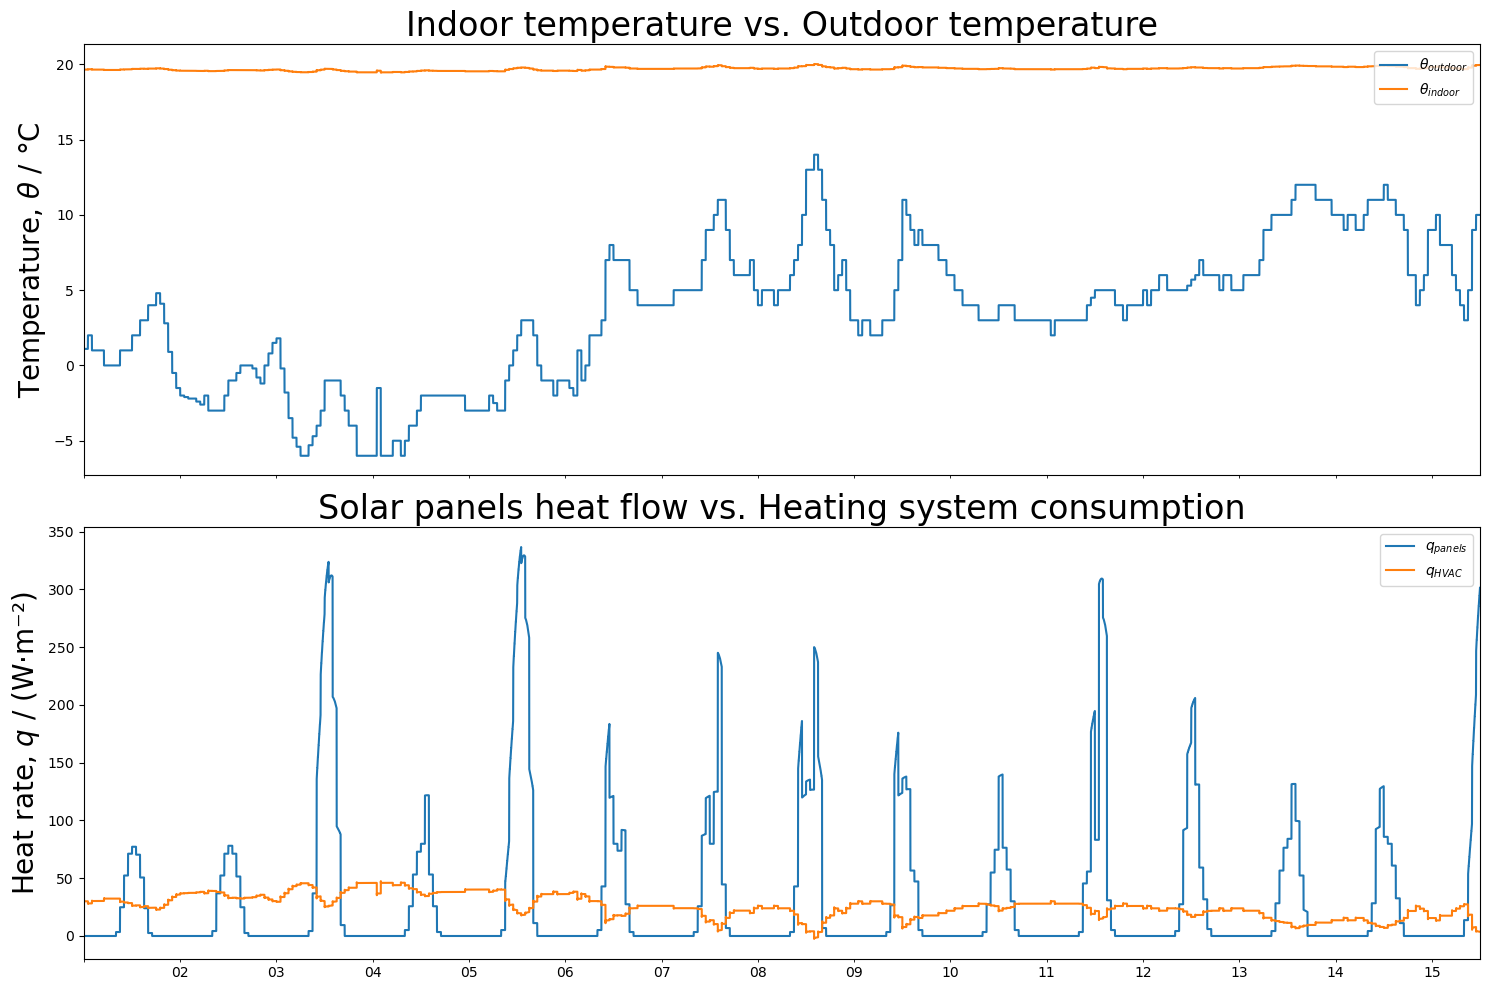

Min. indoor temperature: 19.4540 °C
Max. indoor temperature: 20.0290 °C
Max. load: 47.5 W/m² at 2025-01-04 02:00:50+01:00
Energy consumption: 1032.4 kWh
Max. load panels: 0.3 kW at 2025-01-05 12:59:10+01:00
Energy production of the solar panels: 11.0 kWh
Energy covered by the solar panels: 1.06 %


In [29]:
"Boundary Conditions"
T0 = 20.0 
Ti_sp = 20
Kp = 10000
f_90 = 1000 
plot_radiations = False
mode = 'both' 
summer = False

dt = 50 # seconds

TC = mtt.thermal_circuit(g10,g11,g12,g13,g14,g15,g20,g21,g22,g23,g24,g25,g30,g31,g32,g33,g34,g35,g40,g41,g42,g43,g44,g45,g50,g60,g61,g62,g63,g64,g65,g70,Kp,c12,c14,c22,c24,c32,c34,c42,c44,c62,c64,c00)
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

### Temperature controller working with solar power during summer

Then the controller factor Kp is 12 W/K, the solar panels can cover all the energy demand of the temperature system in summer.

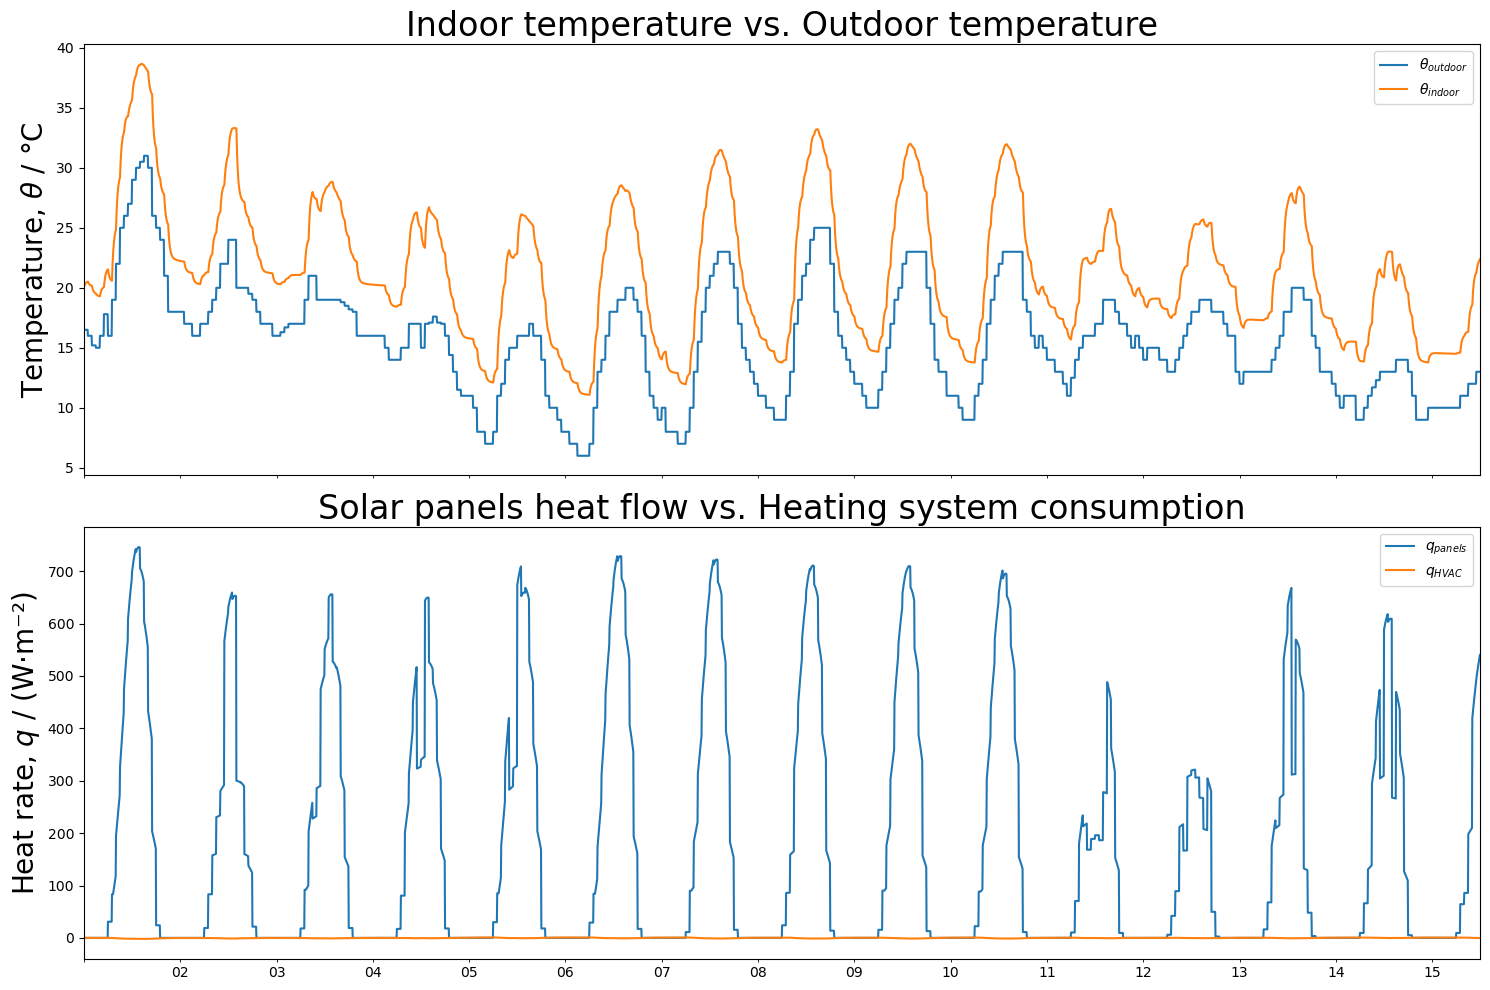

Min. indoor temperature: 11.0778 °C
Max. indoor temperature: 38.6576 °C
Max. load: 0.9 W/m² at 2025-09-06 06:00:00+01:00
Energy consumption: 6.6 kWh
Max. load panels: 0.7 kW at 2025-09-01 13:40:00+01:00
Energy production of the solar panels: 59.2 kWh
Energy covered by the solar panels: 892.54 %


In [30]:
"Boundary Conditions"
T0 = 20.0 
Ti_sp = 20
Kp = 12
f_90 = 1000 
plot_radiations = False
mode = 'both' 
summer = True

dt = 300 # seconds

TC = mtt.thermal_circuit(g10,g11,g12,g13,g14,g15,g20,g21,g22,g23,g24,g25,g30,g31,g32,g33,g34,g35,g40,g41,g42,g43,g44,g45,g50,g60,g61,g62,g63,g64,g65,g70,Kp,c12,c14,c22,c24,c32,c34,c42,c44,c62,c64,c00)
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

### Temperature controller working with solar power during winter

Because of the reduction of the solar radiation, the temperature controller cannot be satisfied with the solar power during the winter. Kp has to be around 0.3, evidencing this factor.

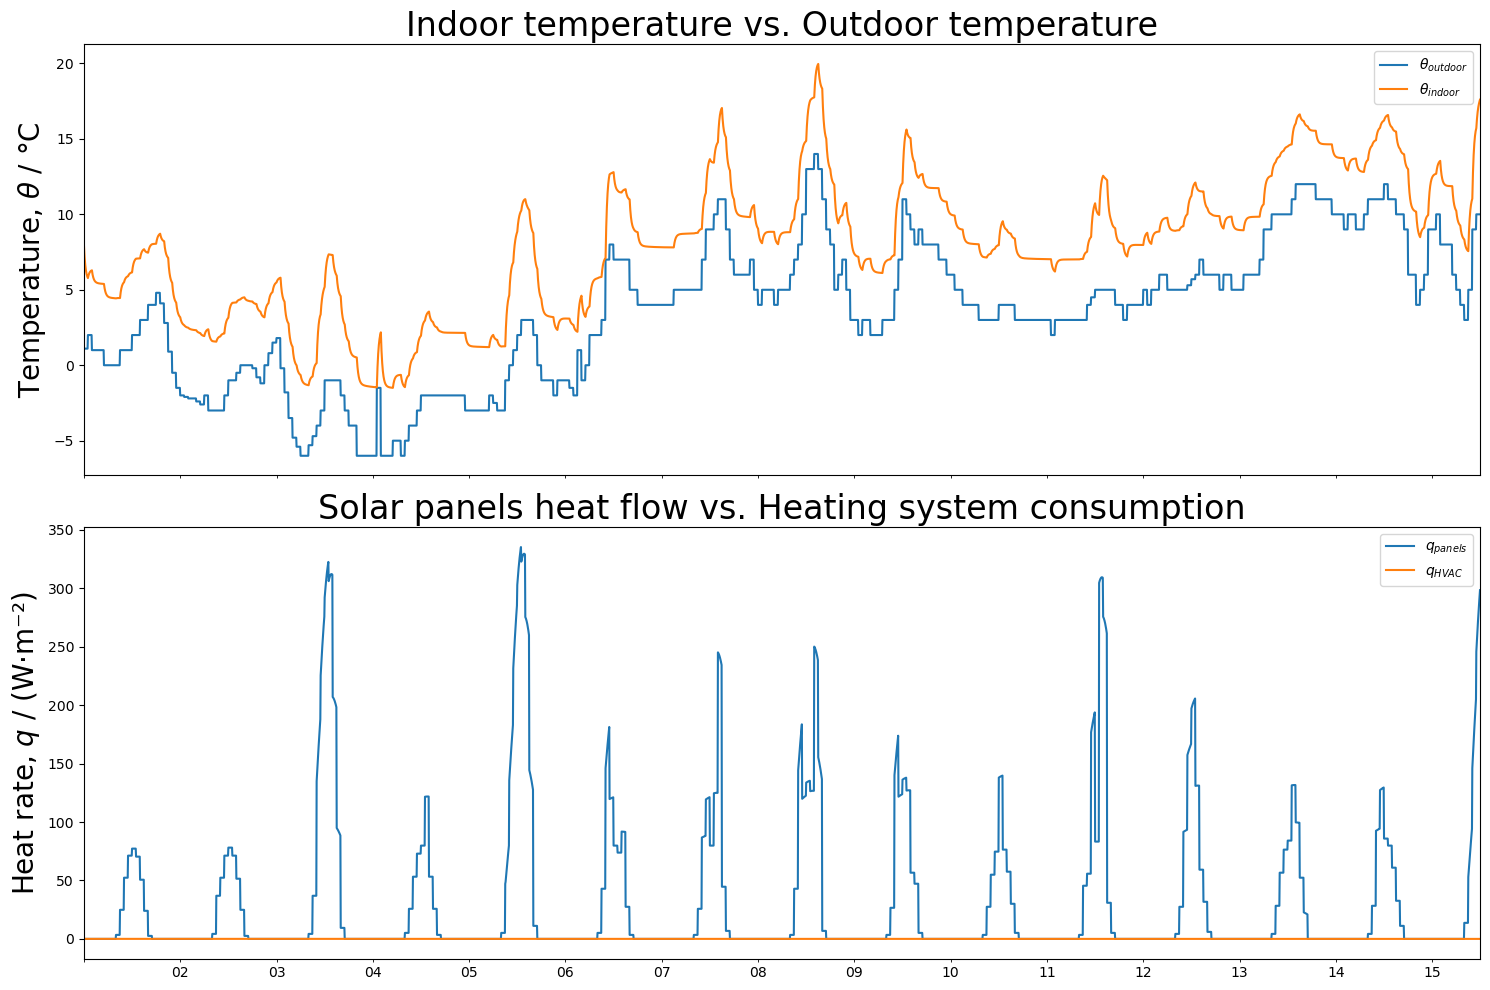

Min. indoor temperature: -1.4987 °C
Max. indoor temperature: 19.9673 °C
Max. load: 0.1 W/m² at 2025-01-04 05:00:00+01:00
Energy consumption: 1.3 kWh
Max. load panels: 0.3 kW at 2025-01-05 12:55:00+01:00
Energy production of the solar panels: 11.0 kWh
Energy covered by the solar panels: 866.33 %


In [31]:
"Boundary Conditions"
T0 = 8.0
Ti_sp = 20
Kp = 0.3
f_90 = 1000 
plot_radiations = False
mode = 'both' 
summer = False

dt = 300 # seconds

TC = mtt.thermal_circuit(g10,g11,g12,g13,g14,g15,g20,g21,g22,g23,g24,g25,g30,g31,g32,g33,g34,g35,g40,g41,g42,g43,g44,g45,g50,g60,g61,g62,g63,g64,g65,g70,Kp,c12,c14,c22,c24,c32,c34,c42,c44,c62,c64,c00)
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

### Real temperature controller during summer

For the real behaviour, it is assumed that the Kp is around 85 W/K. During the summer, the solar power will satisfy around the 18% of the energy demand.

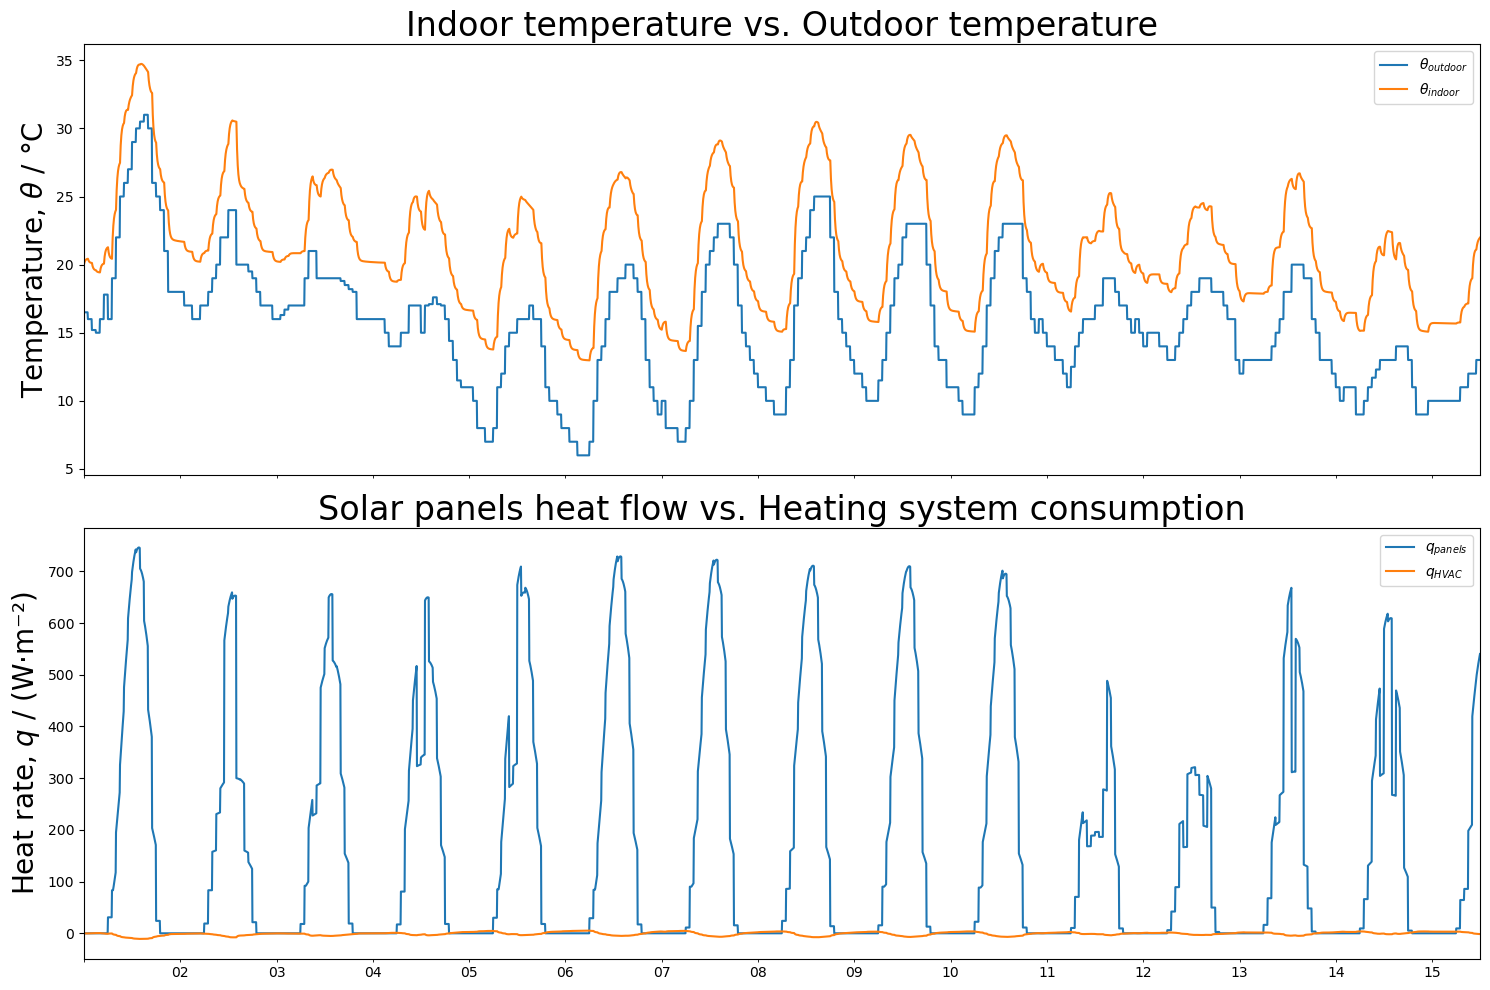

Min. indoor temperature: 12.9730 °C
Max. indoor temperature: 34.7343 °C
Max. load: 5.2 W/m² at 2025-09-06 06:00:00+01:00
Energy consumption: 37.3 kWh
Max. load panels: 0.7 kW at 2025-09-01 13:40:00+01:00
Energy production of the solar panels: 59.2 kWh
Energy covered by the solar panels: 158.57 %


In [32]:
"Boundary Conditions"
T0 = 20.0 
Ti_sp = 20
Kp = 85
f_90 = 1000 
plot_radiations = False
mode = 'both' 
summer = True

dt = 300 # seconds

TC = mtt.thermal_circuit(g10,g11,g12,g13,g14,g15,g20,g21,g22,g23,g24,g25,g30,g31,g32,g33,g34,g35,g40,g41,g42,g43,g44,g45,g50,g60,g61,g62,g63,g64,g65,g70,Kp,c12,c14,c22,c24,c32,c34,c42,c44,c62,c64,c00)
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

### Real temperature controller during winter

During the winter, for exactly the same Kp as during the summer, the solar panels can satisfy only around the 0.5% of the energy demand.

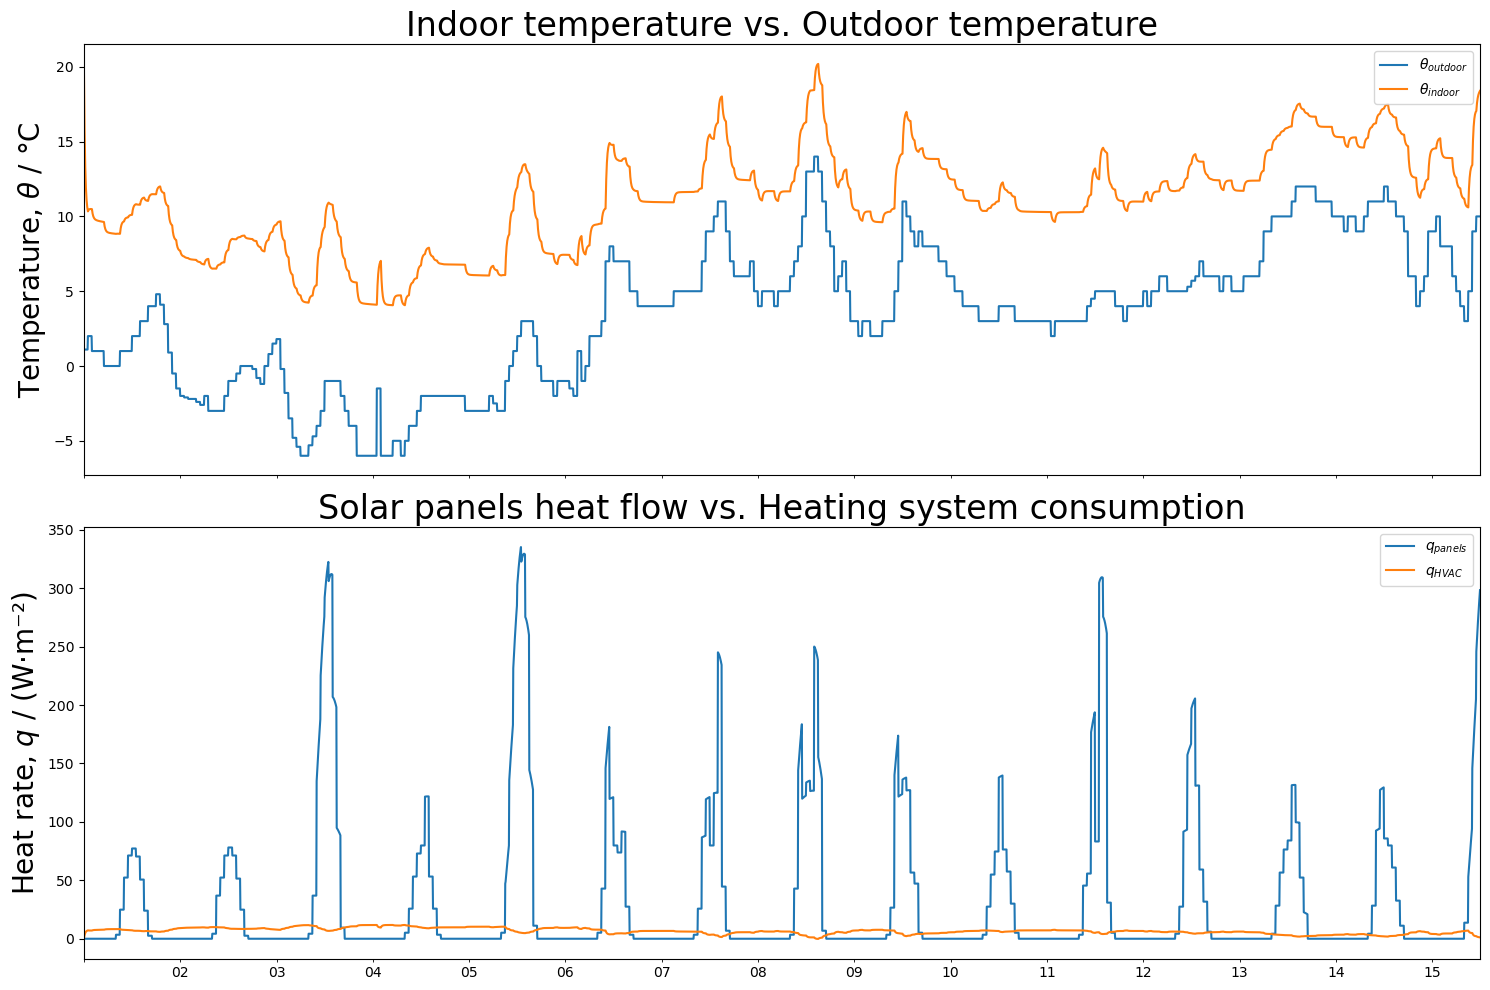

Min. indoor temperature: 4.0632 °C
Max. indoor temperature: 20.1938 °C
Max. load: 11.8 W/m² at 2025-01-04 08:00:00+01:00
Energy consumption: 264.6 kWh
Max. load panels: 0.3 kW at 2025-01-05 12:55:00+01:00
Energy production of the solar panels: 11.0 kWh
Energy covered by the solar panels: 4.14 %


In [33]:
"Boundary Conditions"
T0 = 20.0 
Ti_sp = 20
Kp = 85
f_90 = 1000 
plot_radiations = False
mode = 'both' 
summer = False

dt = 300 # seconds

TC = mtt.thermal_circuit(g10,g11,g12,g13,g14,g15,g20,g21,g22,g23,g24,g25,g30,g31,g32,g33,g34,g35,g40,g41,g42,g43,g44,g45,g50,g60,g61,g62,g63,g64,g65,g70,Kp,c12,c14,c22,c24,c32,c34,c42,c44,c62,c64,c00)
mtt.simulation_weather(weather_data, T0, Ti_sp, f_90, Kp, delta_tmax, t_settle, dt, TC, surfaces, summer, mode, albedo_ground, albedo_roof, α_wSW, α_rSP, τ_gSW, plot_radiations)

## Conclusions

This work implemented and analysed a dynamic thermal model of the second floor of a gas-insulated substation in Dübendorf, using a lumped-parameter RC network built “by hand” and solved via the `dm4bem` framework. Some conclusions that can be made out of it are:
- Under fixed boundary conditions (constant outdoor temperature, no solar radiation, no internal gains, no controller), the system evolves from an arbitrary initial state towards a unique steady state. The approach to steady state is governed by the slowest eigenvalues of the system, illustrating the strong thermal inertia of the walls and internal mass. This justifies using relatively large time steps (hundreds of seconds) without losing relevant dynamics.
- The superposition of solar and internal loads leads to longer periods where the indoor temperature remains well above the outdoor temperature, and potentially above acceptable comfort or equipment-operation limits if no HVAC is present.
- Due to the large heat capacities, the building does not cool down to outdoor conditions overnight, especially following sunny days with high internal dissipation.
- When modelling a perfect controller, the control error is practically zero, so the thermal comfort is fully satisfied. However, the implied heating or cooling demand becomes unrealistically large.
- When the controller gain is reduced, the simulations show that the solar panels can cover essentially all of the heating/cooling demand of the temperature controller. However, the temperature indoor does not get closer to the temperature setpoint given as an input.
- A more realistic controller gain can drive the indoor temperature closer to the setpoint, and be partially satisfied by the energy provided by the solar panels.
- Solar panels on the roof provide a significant auxiliary energy source in summer, but their impact on winter heating demand is minimal with the current area, orientation and envelope. They are therefore better suited as a supporting technology rather than a primary heating source in this configuration.
- The modelling approach, based on a detailed RC network and dm4bem, proved capable of capturing these phenomena consistently across steady-state and transient regimes, and of separating the contributions of different physical processes (weather, solar, internal loads, control).

In summary, the simulations show that the gas-insulated substation behaves as a heavy, solar-sensitive zone where comfort and energy use are jointly determined by envelope design, internal loads, solar radiation and control strategy. While solar panels can substantially assist heating in summer, especially with a suitably tuned controller, they have a limited role for winter heating under the current assumptions. Further improvements would require either enhanced envelope efficiency, larger or differently oriented PV areas, or more advanced control strategies that exploit predictive information about weather and loads.
